In [405]:
import pandas as pd

base_path = "../../data/raw/first_experiment/execution_metrics"

start_time = pd.Timestamp("2025-04-21 19:55:00")
end_time = pd.Timestamp("2025-04-21 21:00:00")

df_container_cpu_usage_seconds_total = pd.read_parquet(base_path + "/container_cpu_usage_seconds_total.parquet")
df_container_memory_usage_bytes = pd.read_parquet(base_path + "/container_memory_usage_bytes.parquet")
df_kube_pod_status_phase = pd.read_parquet(base_path + "/kube_pod_status_phase.parquet")

df_spark_application_running_count = pd.read_parquet(base_path + "/spark_application_running_count.parquet")
df_spark_application_start_latency_seconds_count = pd.read_parquet(base_path + "/spark_application_start_latency_seconds_count.parquet")

bytes_in = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_bytesin_total.parquet")
bytes_out = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_bytesout_total.parquet")
messages_in = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_messagesin_total.parquet")
requests = pd.read_parquet(base_path + "/kafka_network_requestmetrics_requests_total.parquet")
errors = pd.read_parquet(base_path + "/kafka_network_requestmetrics_errors_total.parquet")
consumer_outgoing = pd.read_parquet(base_path + "/kafka_consumer_outgoing_byte.parquet")


In [406]:
def time_filter(df: pd.DataFrame) -> pd.DataFrame:
    df = df[
        (df["timestamp"] >= start_time) &
        (df["timestamp"] <= end_time)
    ]
    return df

In [407]:
df_container_cpu_usage_seconds_total = df_container_cpu_usage_seconds_total.reset_index()
df_container_memory_usage_bytes = df_container_memory_usage_bytes.reset_index()
df_kube_pod_status_phase = df_kube_pod_status_phase.reset_index()

bytes_in = bytes_in.reset_index()
bytes_out = bytes_out.reset_index()
messages_in = messages_in.reset_index()
requests = requests.reset_index()
errors = errors.reset_index()
consumer_outgoing = consumer_outgoing.reset_index()

df_container_cpu_usage_seconds_total = time_filter(df_container_cpu_usage_seconds_total)
df_container_memory_usage_bytes = time_filter(df_container_memory_usage_bytes)
df_kube_pod_status_phase = time_filter(df_kube_pod_status_phase)

bytes_in = time_filter(bytes_in)
bytes_out = time_filter(bytes_out)
messages_in = time_filter(messages_in)
requests = time_filter(requests)
errors = time_filter(errors)
consumer_outgoing = time_filter(consumer_outgoing)

In [ ]:
import re

def simplify_pod_name(pod_name):
    # 1. Remove common hash suffixes (e.g., -6b6bf85947-b67tc or -74c4cb664h8mx)
    pod_name = re.sub(r'-[a-z0-9]{5,}(?=$|-)', '', pod_name)

    # 2. Remove deployment hashes (common in statefulsets/deployments)
    pod_name = re.sub(r'-[a-z0-9]{8,}$', '', pod_name)

    # 3. Replace very long names with initials or shorter known aliases
    known_aliases = {
        'kube-prometheus-stack-prometheus-node-exporter': 'node-exporter',
        'kube-prometheus-stack-kube-state-metrics': 'state-metrics',
        'airbyte-default-connector-builder-server': 'airbyte-builder',
        'airbyte-default-server': 'airbyte-server',
        'airbyte-default-worker': 'airbyte-worker',
        'airbyte-default-workload-launcher': 'airbyte-launcher',
        'labfaber-kafka-schema-registry-cp-schema-registry': 'kafka-schema-registry',
        'labfaber-kafka-exporter': 'kafka-exporter',
        'labfaber-kafka-ui': 'kafka-ui',
        'labfaber-zookeeper': 'zk',
        'labfaber-kafka': 'kafka',
        'longhorn-driver-deployer': 'longhorn-deployer',
        'longhorn-csi-plugin': 'longhorn-csi',
        'longhorn-manager': 'longhorn-mgr',
        'open-metadata-deps-db-migrations': 'om-db-migrations',
        'open-metadata-deps-scheduler': 'om-scheduler',
        'open-metadata-deps-triggerer': 'om-triggerer',
        'open-metadata-deps-web': 'om-web',
        'openmetadata': 'openmetadata',
        'spark-operator-controller': 'spark-ctrl',
        'spark-operator-webhook': 'spark-hook',
        'deltalakewithminio': 'dl-minio',
        'streaming-pipeline-kafka-avro-to-delta-driver': 'spark-driver',
        'deploy-spark-history-server': 'spark-history',
    }
    for long, short in known_aliases.items():
        if pod_name.startswith(long):
            return pod_name.replace(long, short)

    # 4. Trim overly verbose prefixes but keep the key identity
    parts = pod_name.split('-')
    if len(parts) > 3:
        return '-'.join(parts[:3])  # e.g., 'argocd-server-abc123' → 'argocd-server-abc'

    return pod_name


In [408]:
import re

# List of name patterns (stable prefixes)
pod_patterns = [
    'minio-community',
    'labfaber-cruise-control',
    'labfaber-kafka',
    'labfaber-kafka-schema-registry',
    'labfaber-kafka-ui',
    'labfaber-zookeeper',
    'strimzi-cluster-operator',
    'deltalakewithminio',
    'deploy-spark-history-server',
    'streaming-pipeline-kafka-avro-to-delta-driver',
    'spark-operator-controller',
    'spark-operator-webhook',
]

# List of all pods (as a Python list)
all_pods = df_kube_pod_status_phase["pod"].unique()

# Select pods that match any pattern
selected_pods = [pod for pod in all_pods if any(pod.startswith(p) for p in pod_patterns)]


In [409]:
df_kube_pod_status_phase = df_kube_pod_status_phase[df_kube_pod_status_phase["pod"].isin(selected_pods)]

In [410]:
df_container_cpu_usage_seconds_total_filtered = df_container_cpu_usage_seconds_total[df_container_cpu_usage_seconds_total["pod"].isin(selected_pods)]

In [411]:
def get_true_spark_run_starts(df_status):
    """
    Extracts Spark driver/executor start times by identifying the first Running phase
    that is not followed by a terminal phase (Pending, Failed, Succeeded, etc.)
    """
    spark_df = df_status[
        (df_status['pod'].str.contains('driver|exec', case=False)) &
        (df_status['value'] == 1.0)
    ].sort_values(['timestamp', 'pod'])

    valid_starts = []

    for pod, pod_df in spark_df.groupby('pod'):
        phases = pod_df[['timestamp', 'phase']].values
        for i, (ts, phase) in enumerate(phases):
            if phase != 'Running':
                continue
            # Check if there's any non-running *after* this point
            future_phases = [p for _, p in phases[i+1:]]
            if all(p == 'Running' for p in future_phases):
                # Running never ends
                valid_starts.append((pod, ts))
                break
            if any(p in ['Failed', 'Succeeded', 'Pending', 'Unknown'] for p in future_phases):
                # This is a real start that will transition
                valid_starts.append((pod, ts))
                break

    return pd.DataFrame(valid_starts, columns=['pod', 'timestamp'])


In [412]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def annotate_spark_starts(ax, df, node = None, pod_color_map = None, top_offset=0.5, top_offset_inc=0.2, label_offset_secs=60):
    """
    Annotates spark driver/executor start times on a matplotlib axis.

    Parameters:
        ax (matplotlib.axes.Axes): The axis to annotate.
        df (pd.DataFrame): The full CPU or metric DataFrame with 'timestamp', 'pod', 'node'.
        node (str): Node name for filtering.
        pod_color_map (dict): Maps pod name to color.
        top_offset (float): Vertical placement (fraction of y-axis height).
        label_offset_secs (int): Time offset for text label placement (in seconds).
    """

    def format_spark_label(pod_name):
        if "driver" in pod_name:
            return "Driver"
        elif "exec" in pod_name:
            return f"Exc-{pod_name.split('-exec-')[-1]}"
        return pod_name  # fallback

    spark_pod_starts = get_true_spark_run_starts(df_kube_pod_status_phase)

    spark_pod_starts.sort_values(['timestamp', 'pod'])

    # Create a color map if not provided
    if pod_color_map is None:
        unique_pods = spark_pod_starts['pod'].unique()
        cmap = plt.get_cmap('tab10', len(unique_pods))  # or 'Set1', 'tab20'
        pod_color_map = {pod: mcolors.to_hex(cmap(i)) for i, pod in enumerate(unique_pods)}

    for pod, ts in spark_pod_starts.itertuples(index=False):
        if pod not in pod_color_map:
            continue
        if node:
            pod_node_df = df[(df['pod'] == pod) & (df['node'] == node)]
            if pod_node_df.empty:
                continue

        color = pod_color_map[pod]
        label_text = format_spark_label(pod)

        ax.axvline(x=ts, color=color, linestyle='-.', linewidth=1.5)

        ymin, ymax = ax.get_ylim()
        y_pos = ymin + (ymax - ymin) * top_offset

        ax.text(
            ts + pd.Timedelta(seconds=label_offset_secs),
            y_pos,
            label_text,
            rotation=90,
            fontsize=8,
            color=color,
            ha='left',
            va='top',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.2')
        )
        top_offset += top_offset_inc


# Plot spark application running status

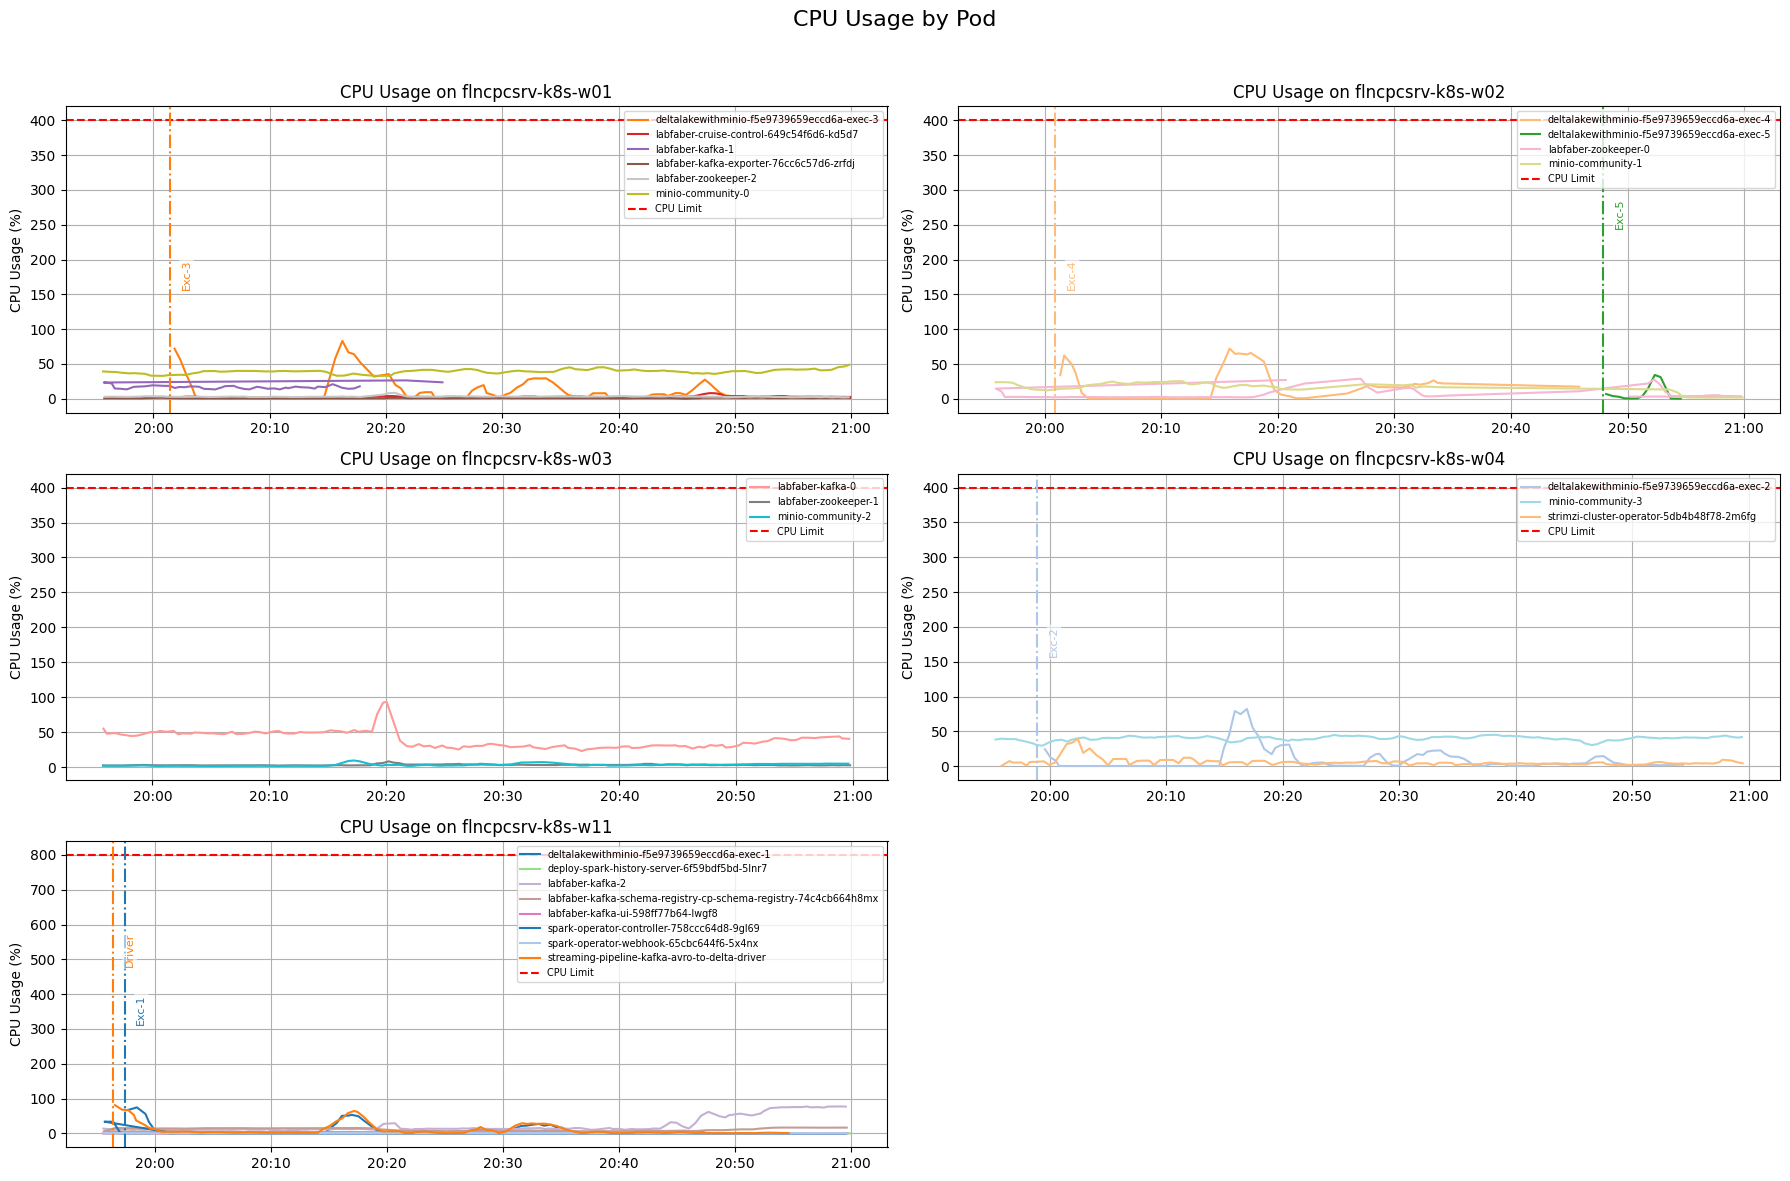

In [413]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

df = df_container_cpu_usage_seconds_total_filtered.sort_values(by=['id', 'pod', 'timestamp']).dropna(subset="container")

# Calculate diffs and remove resets
df['value_diff'] = df.groupby('id')['value'].diff()
df['time_diff'] = df.groupby('id')['timestamp'].diff().dt.total_seconds()
df = df[(df['value_diff'] > 0) & (df['time_diff'] > 0)].copy()

# Compute CPU rate as % and apply a 3-point rolling average
df['rate'] = (df['value_diff'] / df['time_diff']) * 100
df['cpu_percent'] = df.groupby('pod')['rate'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# === Step 2: Clip CPU usage based on node limits ===
node_cpu_limits = {
    'flncpcsrv-k8s-w01': 400,
    'flncpcsrv-k8s-w02': 400,
    'flncpcsrv-k8s-w03': 400,
    'flncpcsrv-k8s-w04': 400,
    'flncpcsrv-k8s-w11': 800,
}
df['cpu_limit'] = df['node'].map(node_cpu_limits)

# === Step 3: Assign consistent categorical colors to pods ===
unique_pods = sorted(df['pod'].unique())
palette = plt.get_cmap('tab20')  # can use 'Set1', 'Dark2', etc. for more contrast
colors = [palette(i % palette.N) for i in range(len(unique_pods))]
pod_color_map = dict(zip(unique_pods, colors))

# === Step 4: Plot CPU usage by node with consistent colors ===
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12), sharex=False)
axes = axes.flatten()

for i, node in enumerate(node_cpu_limits.keys()):
    ax = axes[i]
    node_data = df[df['node'] == node]

    for pod_name, pod_df in node_data.groupby('pod'):
        ax.plot(
            pod_df['timestamp'],
            pod_df['cpu_percent'],
            label=pod_name,
            color=pod_color_map[pod_name]
        )

    ax.set_title(f"CPU Usage on {node}")
    ax.set_ylabel("CPU Usage (%)")
    ax.axhline(y=node_cpu_limits[node], color='red', linestyle='--', label='CPU Limit')

    # === Reusable annotation call ===
    annotate_spark_starts(ax, df, node, pod_color_map)
    
    ax.legend(loc='upper right', fontsize='x-small')
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Hide unused subplot
if len(axes) > len(node_cpu_limits):
    for j in range(len(node_cpu_limits), len(axes)):
        fig.delaxes(axes[j])

axes[-1].set_xlabel("Time")
fig.suptitle("CPU Usage by Pod", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


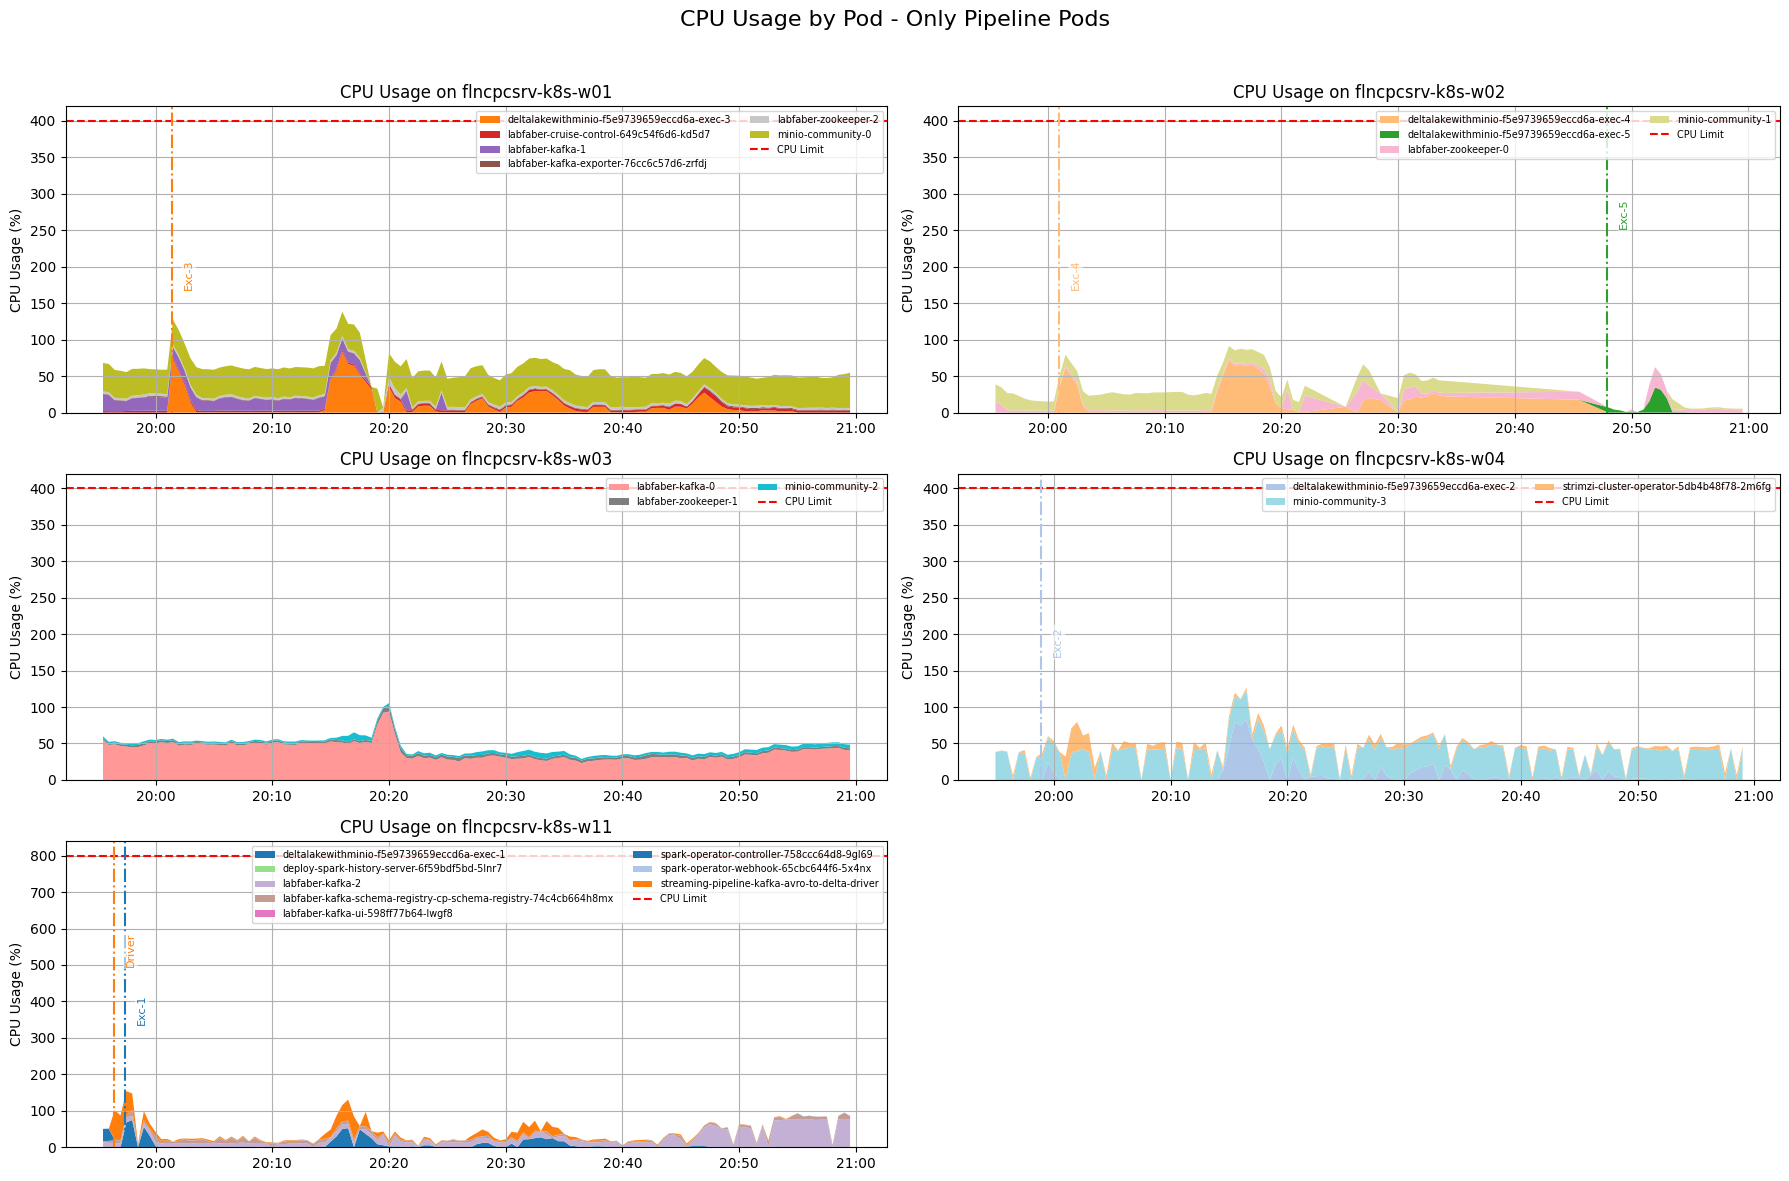

In [414]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

# === Step 1: Preprocess Raw Data ===
df = df_container_cpu_usage_seconds_total_filtered.sort_values(by=['id', 'pod', 'timestamp']).dropna(subset="container")

df['value_diff'] = df.groupby('id')['value'].diff()
df['time_diff'] = df.groupby('id')['timestamp'].diff().dt.total_seconds()
df = df[(df['value_diff'] > 0) & (df['time_diff'] > 0)].copy()

df['rate'] = (df['value_diff'] / df['time_diff']) * 100
df['cpu_percent'] = df.groupby('pod')['rate'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

node_cpu_limits = {
    'flncpcsrv-k8s-w01': 400,
    'flncpcsrv-k8s-w02': 400,
    'flncpcsrv-k8s-w03': 400,
    'flncpcsrv-k8s-w04': 400,
    'flncpcsrv-k8s-w11': 800,
}
df['cpu_limit'] = df['node'].map(node_cpu_limits)


# === Step 2: Keep only necessary columns and resample ===
df_resampled = (
    df[['timestamp', 'node', 'pod', 'cpu_percent']]
    .set_index('timestamp')
    .groupby(['node', 'pod'])
    .resample('30s')
    .mean(numeric_only=True)  # Ensures only numeric values are averaged
    .reset_index()
)

# === Step 3: Plotting Setup ===
unique_pods = sorted(df['pod'].unique())
palette = plt.get_cmap('tab20')
colors = [palette(i % palette.N) for i in range(len(unique_pods))]
pod_color_map = dict(zip(unique_pods, colors))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12), sharex=False)
axes = axes.flatten()

for i, node in enumerate(node_cpu_limits.keys()):
    ax = axes[i]
    node_data = df_resampled[df_resampled['node'] == node]

    if node_data.empty:
        ax.set_visible(False)
        continue

    pivot_df = node_data.pivot_table(
        index='timestamp',
        columns='pod',
        values='cpu_percent',
        aggfunc='mean'
    ).fillna(0).sort_index()

    present_pods = pivot_df.columns.tolist()
    colors_present = [pod_color_map[pod] for pod in present_pods]

    ax.stackplot(
        pivot_df.index,
        pivot_df.T.values,
        labels=present_pods,
        colors=colors_present
    )

    ax.set_title(f"CPU Usage on {node}")
    ax.set_ylabel("CPU Usage (%)")
    ax.axhline(y=node_cpu_limits[node], color='red', linestyle='--', label='CPU Limit')

    # === Reusable annotation call ===
    annotate_spark_starts(ax, df, node, pod_color_map)

    ax.legend(loc='upper right', fontsize='x-small', ncol=2)
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Hide unused subplots
for j in range(len(node_cpu_limits), len(axes)):
    fig.delaxes(axes[j])

axes[-1].set_xlabel("Time")
fig.suptitle("CPU Usage by Pod - Only Pipeline Pods", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

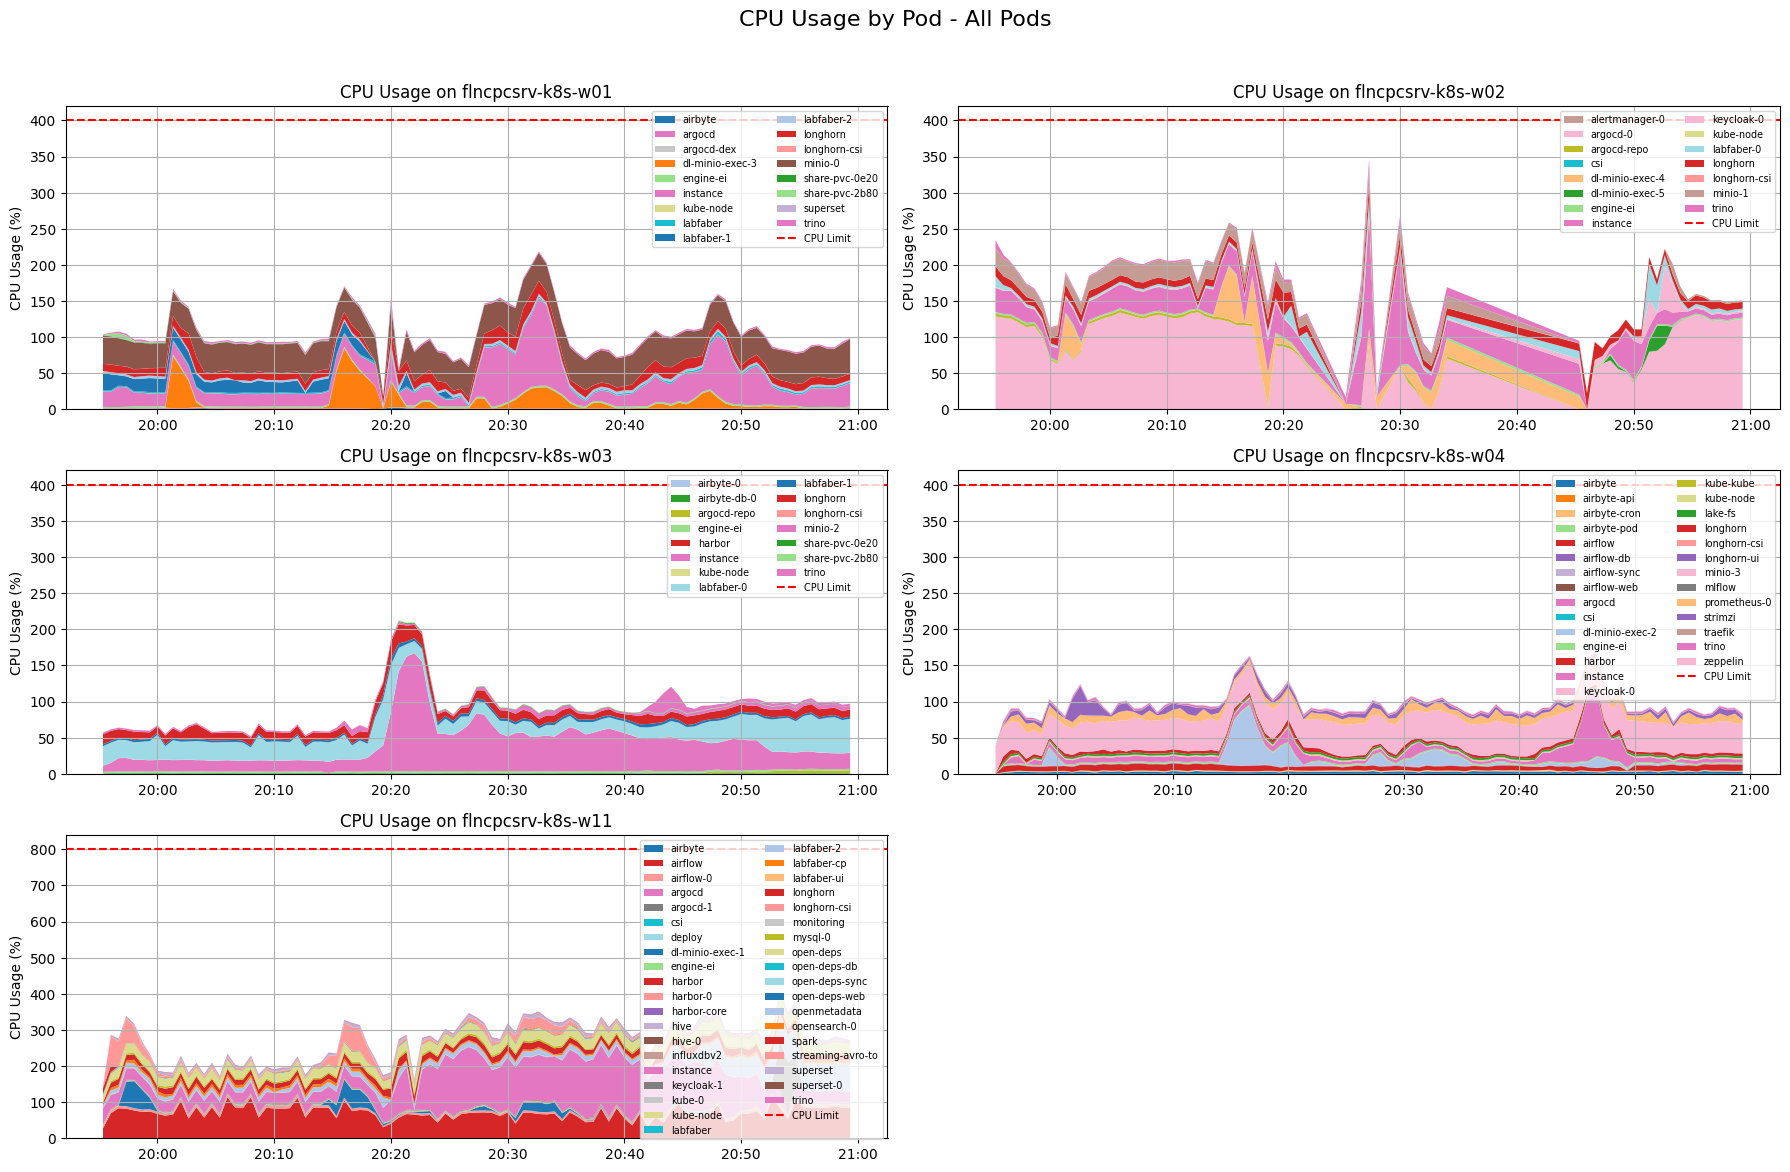

In [439]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

# === Step 1: Preprocess Raw Data ===
df = df_container_cpu_usage_seconds_total.sort_values(by=['id', 'pod', 'timestamp']).dropna(subset="container")

df["pod"] = df["pod"].apply(simplify_pod_name)

df['value_diff'] = df.groupby('id')['value'].diff()
df['time_diff'] = df.groupby('id')['timestamp'].diff().dt.total_seconds()
df = df[(df['value_diff'] > 0) & (df['time_diff'] > 0)].copy()

df['rate'] = (df['value_diff'] / df['time_diff']) * 100
df['cpu_percent'] = df.groupby('pod')['rate'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

node_cpu_limits = {
    'flncpcsrv-k8s-w01': 400,
    'flncpcsrv-k8s-w02': 400,
    'flncpcsrv-k8s-w03': 400,
    'flncpcsrv-k8s-w04': 400,
    'flncpcsrv-k8s-w11': 800,
}
df['cpu_limit'] = df['node'].map(node_cpu_limits)

# === Step 2: Keep only necessary columns and resample ===
df_resampled = (
    df[['timestamp', 'node', 'pod', 'cpu_percent']]
    .set_index('timestamp')
    .groupby(['node', 'pod'])
    .resample('40s')
    .mean(numeric_only=True)  # Ensures only numeric values are averaged
    .reset_index()
)

# === Step 3: Plotting Setup ===
unique_pods = sorted(df['pod'].unique())
palette = plt.get_cmap('tab20')
colors = [palette(i % palette.N) for i in range(len(unique_pods))]
pod_color_map = dict(zip(unique_pods, colors))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12), sharex=False)
axes = axes.flatten()

for i, node in enumerate(node_cpu_limits.keys()):
    ax = axes[i]
    node_data = df_resampled[df_resampled['node'] == node]

    if node_data.empty:
        ax.set_visible(False)
        continue

    pivot_df = node_data.pivot_table(
        index='timestamp',
        columns='pod',
        values='cpu_percent',
        aggfunc='mean'
    ).fillna(0).sort_index()

    present_pods = pivot_df.columns.tolist()
    colors_present = [pod_color_map[pod] for pod in present_pods]

    ax.stackplot(
        pivot_df.index,
        pivot_df.T.values,
        labels=present_pods,
        colors=colors_present
    )

    ax.set_title(f"CPU Usage on {node}")
    ax.set_ylabel("CPU Usage (%)")
    ax.axhline(y=node_cpu_limits[node], color='red', linestyle='--', label='CPU Limit')
    
    ax.legend(loc='upper right', fontsize='x-small', ncol=2)
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Hide unused subplots
for j in range(len(node_cpu_limits), len(axes)):
    fig.delaxes(axes[j])

axes[-1].set_xlabel("Time")
fig.suptitle("CPU Usage by Pod - All Pods", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


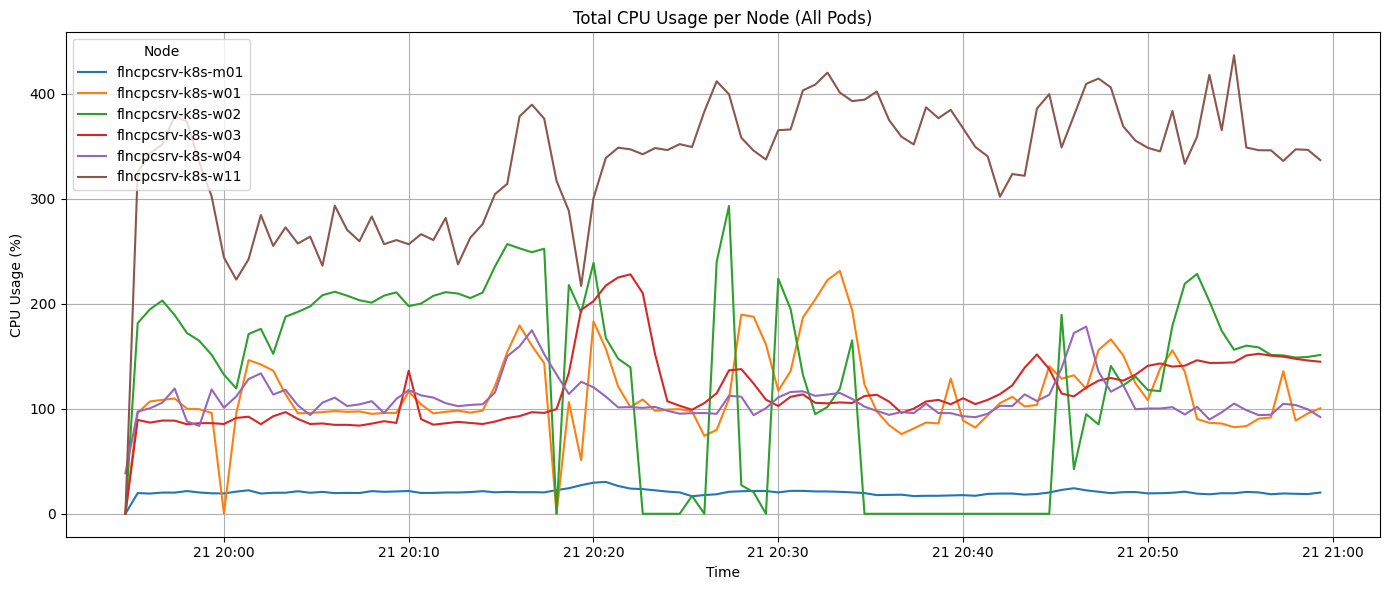

In [416]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load your CPU dataset
cpu_df = df_container_cpu_usage_seconds_total.sort_values(by=['id', 'pod', 'timestamp']).dropna(subset="container")

# === Preprocess CPU usage ===
cpu_df_proc = df_container_cpu_usage_seconds_total.copy()
cpu_df_proc["value_diff"] = cpu_df_proc.groupby("id")["value"].diff()
cpu_df_proc["time_diff"] = cpu_df_proc.groupby("id")["timestamp"].diff().dt.total_seconds()
cpu_df_proc = cpu_df_proc[(cpu_df_proc["value_diff"] > 0) & (cpu_df_proc["time_diff"] > 0)].copy()

cpu_df_proc["rate"] = (cpu_df_proc["value_diff"] / cpu_df_proc["time_diff"]) * 100
cpu_df_proc["cpu_percent"] = cpu_df_proc.groupby("pod")["rate"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

df_resampled = (
    cpu_df_proc[['timestamp', 'node', 'pod', 'cpu_percent']]
    .set_index('timestamp')
    .groupby(['node', 'pod'])
    .resample('40s')
    .mean(numeric_only=True)
    .reset_index()
)

# === Step 3: Sum CPU usage per node and timestamp ===
df_node_total_cpu = (
    df_resampled
    .groupby(['timestamp', 'node'])['cpu_percent']
    .sum()
    .unstack(level='node')
    .fillna(0)
)

# === Step 4: Plotting ===
plt.figure(figsize=(14, 6))
for node in df_node_total_cpu.columns:
    plt.plot(df_node_total_cpu.index, df_node_total_cpu[node], label=node)

plt.title("Total CPU Usage per Node (All Pods)")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend(title="Node")
plt.grid(True)
plt.tight_layout()
plt.show()


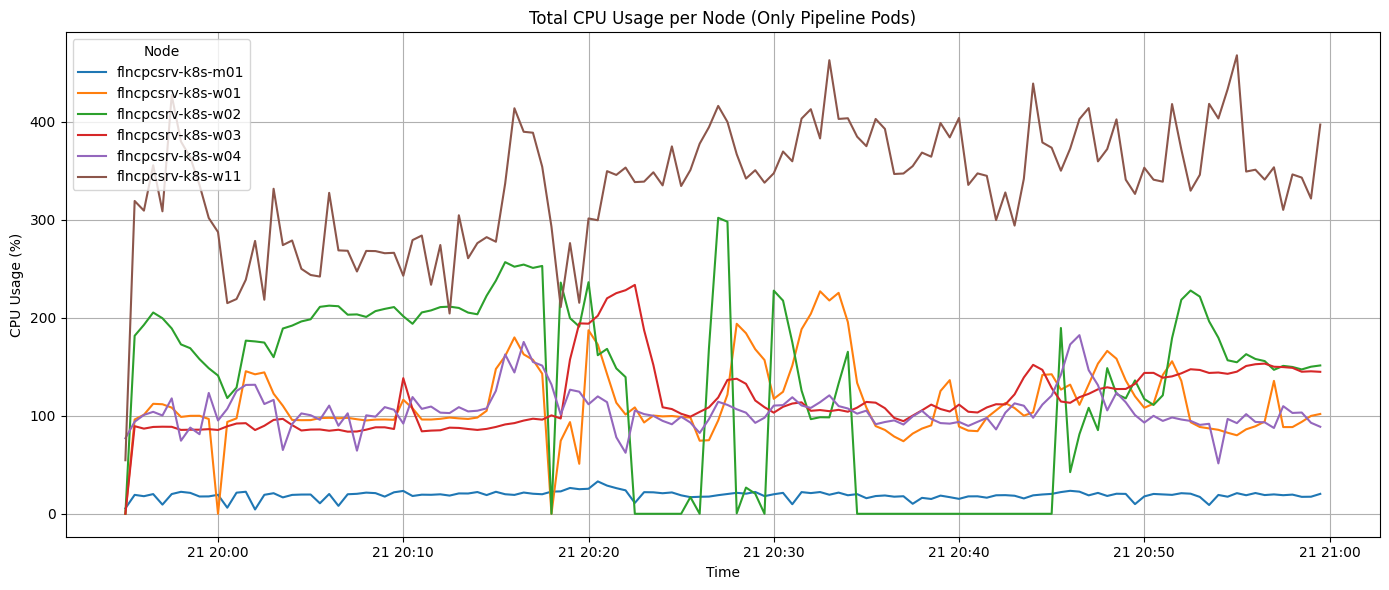

In [417]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load your CPU dataset
cpu_df = df_container_cpu_usage_seconds_total_filtered.sort_values(by=['id', 'pod', 'timestamp']).dropna(subset="container")

# === Preprocess CPU usage ===
cpu_df_proc = df_container_cpu_usage_seconds_total.copy()
cpu_df_proc["value_diff"] = cpu_df_proc.groupby("id")["value"].diff()
cpu_df_proc["time_diff"] = cpu_df_proc.groupby("id")["timestamp"].diff().dt.total_seconds()
cpu_df_proc = cpu_df_proc[(cpu_df_proc["value_diff"] > 0) & (cpu_df_proc["time_diff"] > 0)].copy()

cpu_df_proc["rate"] = (cpu_df_proc["value_diff"] / cpu_df_proc["time_diff"]) * 100
cpu_df_proc["cpu_percent"] = cpu_df_proc.groupby("pod")["rate"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

df_resampled = (
    cpu_df_proc[['timestamp', 'node', 'pod', 'cpu_percent']]
    .set_index('timestamp')
    .groupby(['node', 'pod'])
    .resample('30s')
    .mean(numeric_only=True)
    .reset_index()
)

# === Step 3: Sum CPU usage per node and timestamp ===
df_node_total_cpu = (
    df_resampled
    .groupby(['timestamp', 'node'])['cpu_percent']
    .sum()
    .unstack(level='node')
    .fillna(0)
)

# === Step 4: Plotting ===
plt.figure(figsize=(14, 6))
for node in df_node_total_cpu.columns:
    plt.plot(df_node_total_cpu.index, df_node_total_cpu[node], label=node)

plt.title("Total CPU Usage per Node (Only Pipeline Pods)")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend(title="Node")
plt.grid(True)
plt.tight_layout()
plt.show()


In [418]:
df_container_memory_usage_bytes_filtered = df_container_memory_usage_bytes[df_container_memory_usage_bytes["pod"].isin(selected_pods)]

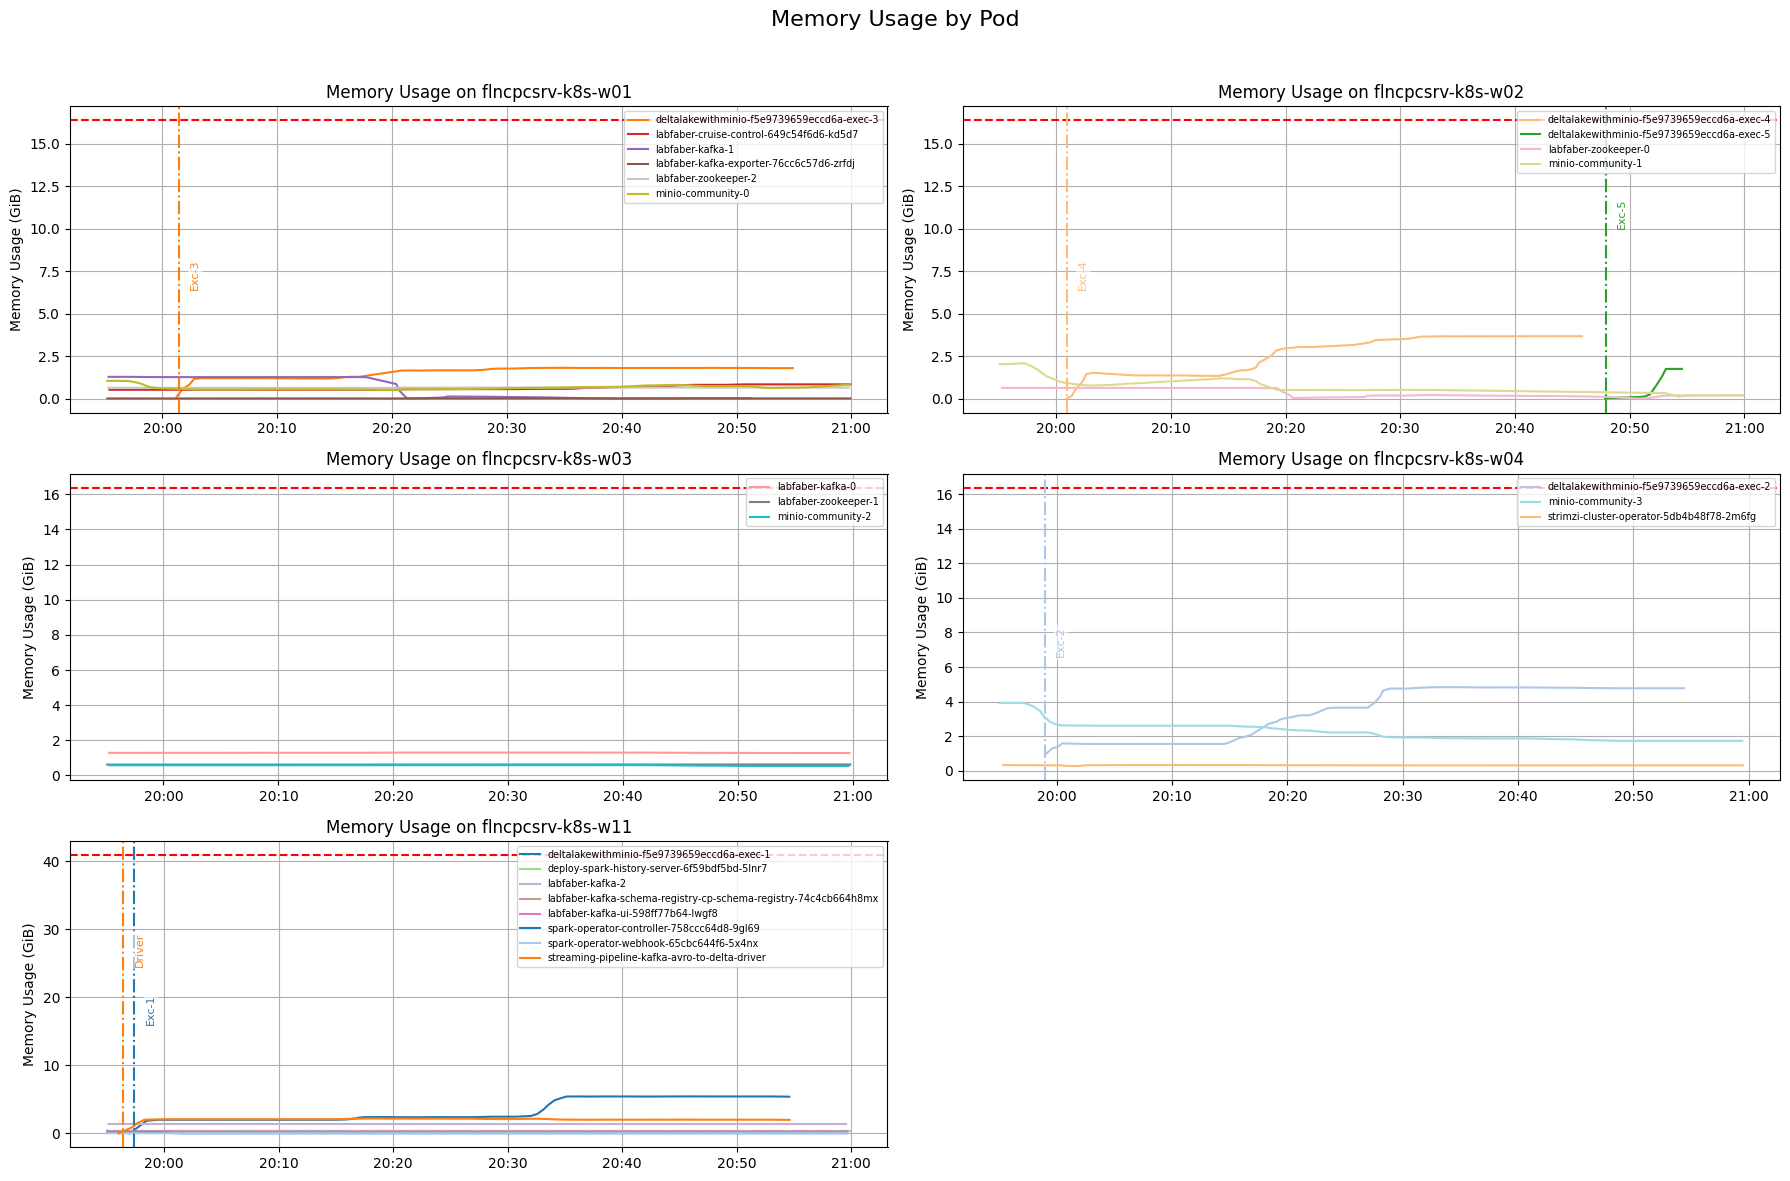

In [419]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

memory_df = df_container_memory_usage_bytes_filtered.sort_values(by=['pod', 'timestamp']).dropna(subset="container").copy()

# Convert from bytes to MiB
memory_df['memory_gib'] = memory_df['value'] / (1024 * 1024 * 1024) # Gib

# Apply 3-point rolling average to smooth
memory_df['memory_gib_smoothed'] = memory_df.groupby('pod')['memory_gib'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Add memory limits in MiB
node_memory_limits = {
    'flncpcsrv-k8s-w01': 16.384,   # 16 GiB
    'flncpcsrv-k8s-w02': 16.384,
    'flncpcsrv-k8s-w03': 16.384,
    'flncpcsrv-k8s-w04': 16.384,
    'flncpcsrv-k8s-w11': 40.960,   # 40 GiB
}
memory_df['memory_limit'] = memory_df['node'].map(node_memory_limits)

# === Step 2: Assign consistent categorical colors to pods ===
unique_pods = sorted(memory_df['pod'].unique())
palette = plt.get_cmap('tab20')
colors = [palette(i % palette.N) for i in range(len(unique_pods))]
pod_color_map = dict(zip(unique_pods, colors))

# === Step 3: Plot smoothed memory usage by node ===
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12), sharex=False)
axes = axes.flatten()

for i, node in enumerate(node_memory_limits.keys()):
    ax = axes[i]
    node_data = memory_df[memory_df['node'] == node]

    for pod_name, pod_df in node_data.groupby('pod'):
        ax.plot(
            pod_df['timestamp'],
            pod_df['memory_gib_smoothed'],
            label=pod_name,
            color=pod_color_map[pod_name]
        )

    ax.set_title(f"Memory Usage on {node}")
    ax.set_ylabel("Memory Usage (GiB)")
    ax.legend(loc='upper right', fontsize='x-small')

    ax.axhline(y=node_memory_limits[node], color='red', linestyle='--', label='CPU Limit')
    
    # === Reusable annotation call ===
    annotate_spark_starts(ax, memory_df, node, pod_color_map)

    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Hide any unused subplot
if len(axes) > len(node_memory_limits):
    for j in range(len(node_memory_limits), len(axes)):
        fig.delaxes(axes[j])

axes[-1].set_xlabel("Time")
fig.suptitle("Memory Usage by Pod", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


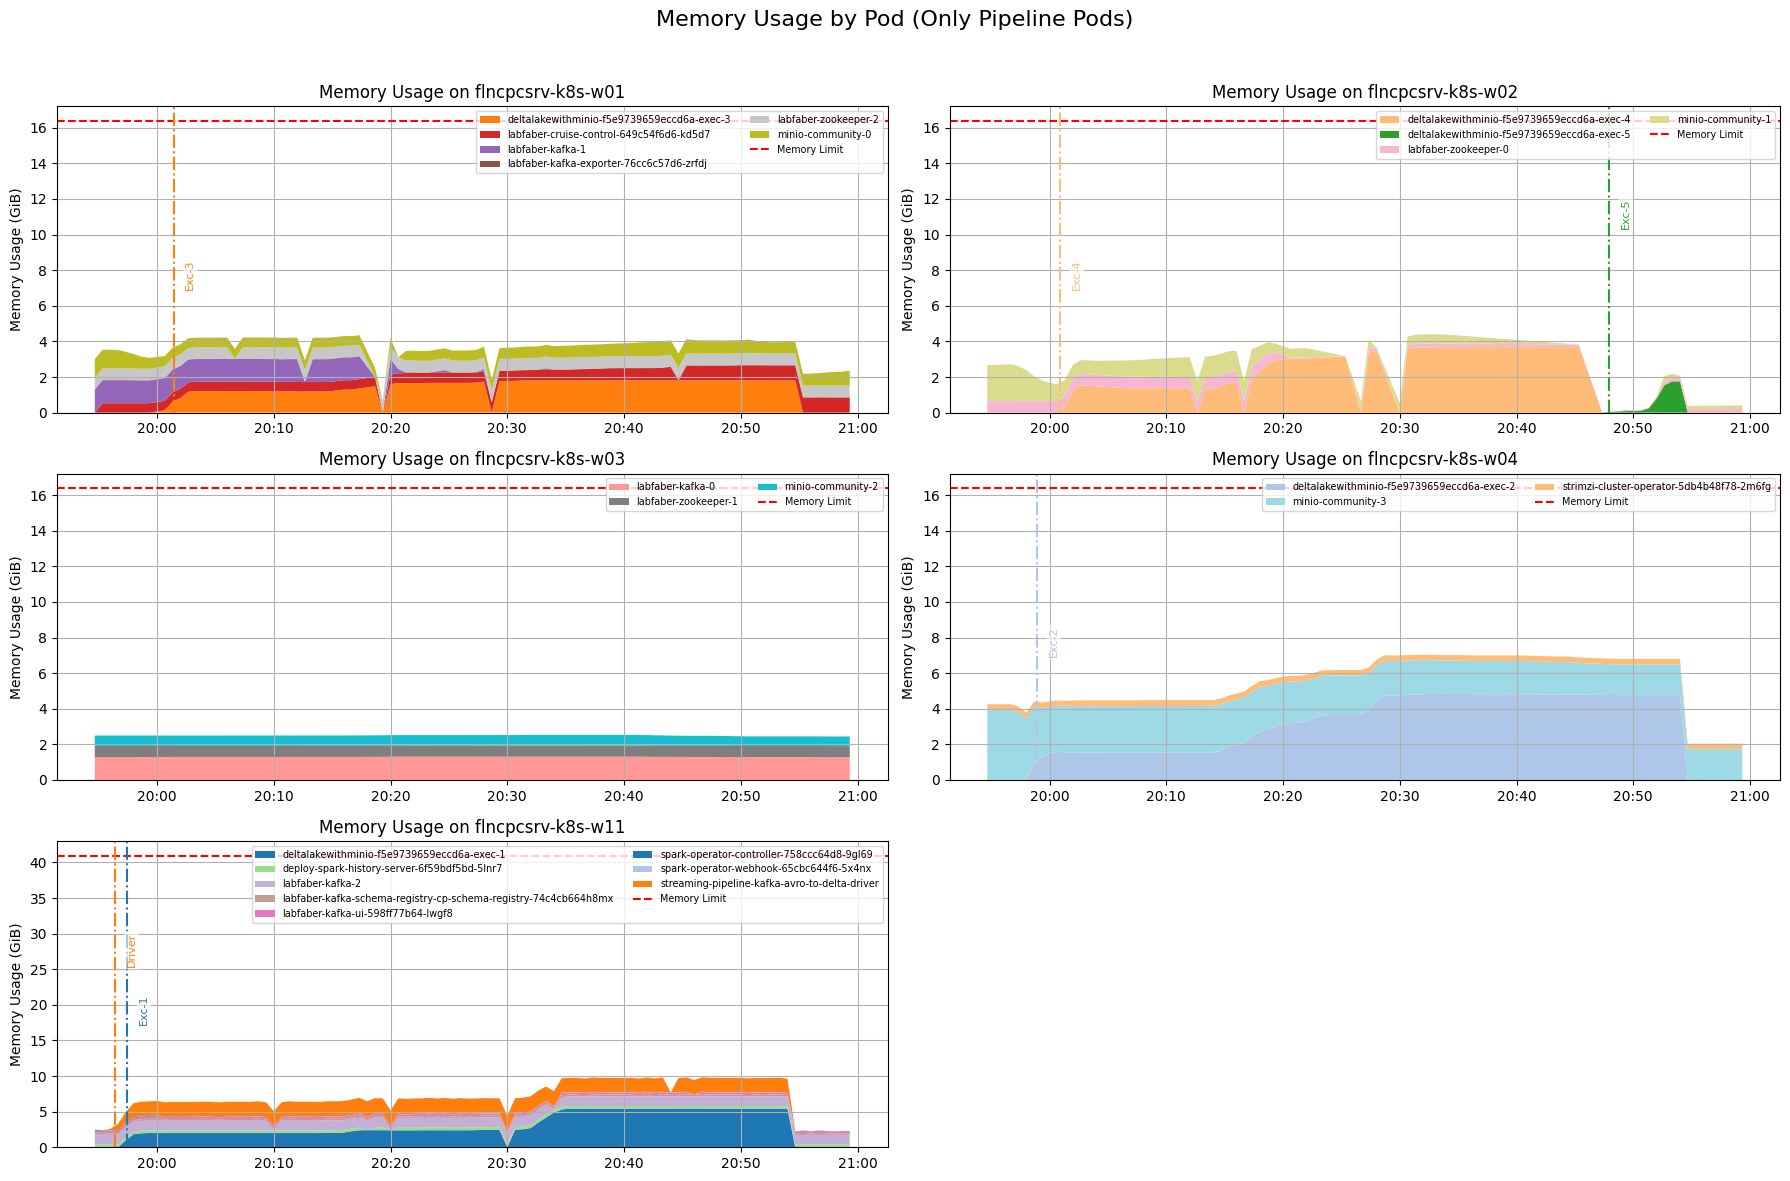

In [420]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

# === Step 1: Preprocessing ===
memory_df = df_container_memory_usage_bytes_filtered.sort_values(by=['timestamp', 'pod']).dropna(subset="container").copy()

# Convert bytes to MiB
memory_df['memory_gib'] = memory_df['value'] / (1024 * 1024 * 1024) # Gib

# Smooth using rolling average
memory_df['memory_gib_smoothed'] = memory_df.groupby('pod')['memory_gib'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Add memory limits in MiB
node_memory_limits = {
    'flncpcsrv-k8s-w01': 16.384,   # 16 GiB
    'flncpcsrv-k8s-w02': 16.384,
    'flncpcsrv-k8s-w03': 16.384,
    'flncpcsrv-k8s-w04': 16.384,
    'flncpcsrv-k8s-w11': 40.960,   # 40 GiB
}
memory_df['memory_limit'] = memory_df['node'].map(node_memory_limits)

# === Step 2: Resample every 30 seconds ===
memory_resampled = (
    memory_df[['timestamp', 'node', 'pod', 'id', 'memory_gib_smoothed']]
    .set_index('timestamp')
    .groupby(['node', 'pod', 'id'])
    .resample('40s')
    .mean(numeric_only=True)
    .reset_index()
)

# === Step 3: Color Palette ===
unique_pods = sorted(memory_df['pod'].unique())
palette = plt.get_cmap('tab20')
colors = [palette(i % palette.N) for i in range(len(unique_pods))]
pod_color_map = dict(zip(unique_pods, colors))

# === Step 4: Plotting ===
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12), sharex=False)
axes = axes.flatten()

for i, node in enumerate(node_memory_limits.keys()):
    ax = axes[i]
    node_data = memory_resampled[memory_resampled['node'] == node]

    if node_data.empty:
        ax.set_visible(False)
        continue

    pivot_df = node_data.pivot_table(
        index='timestamp',
        columns='pod',
        values='memory_gib_smoothed',
        aggfunc='mean'
    ).fillna(0).sort_index()

    present_pods = pivot_df.columns.tolist()
    colors_present = [pod_color_map[pod] for pod in present_pods]

    ax.stackplot(
        pivot_df.index,
        pivot_df.T.values,
        labels=present_pods,
        colors=colors_present
    )

    ax.set_title(f"Memory Usage on {node}")
    ax.set_ylabel("Memory Usage (GiB)")
    ax.axhline(y=node_memory_limits[node], color='red', linestyle='--', label='Memory Limit')

    # === Reusable annotation call ===
    annotate_spark_starts(ax, memory_df, node, pod_color_map)
    
    ax.legend(loc='upper right', fontsize='x-small', ncol=2)
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Remove unused plots
for j in range(len(node_memory_limits), len(axes)):
    fig.delaxes(axes[j])

axes[-1].set_xlabel("Time")
fig.suptitle("Memory Usage by Pod (Only Pipeline Pods)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


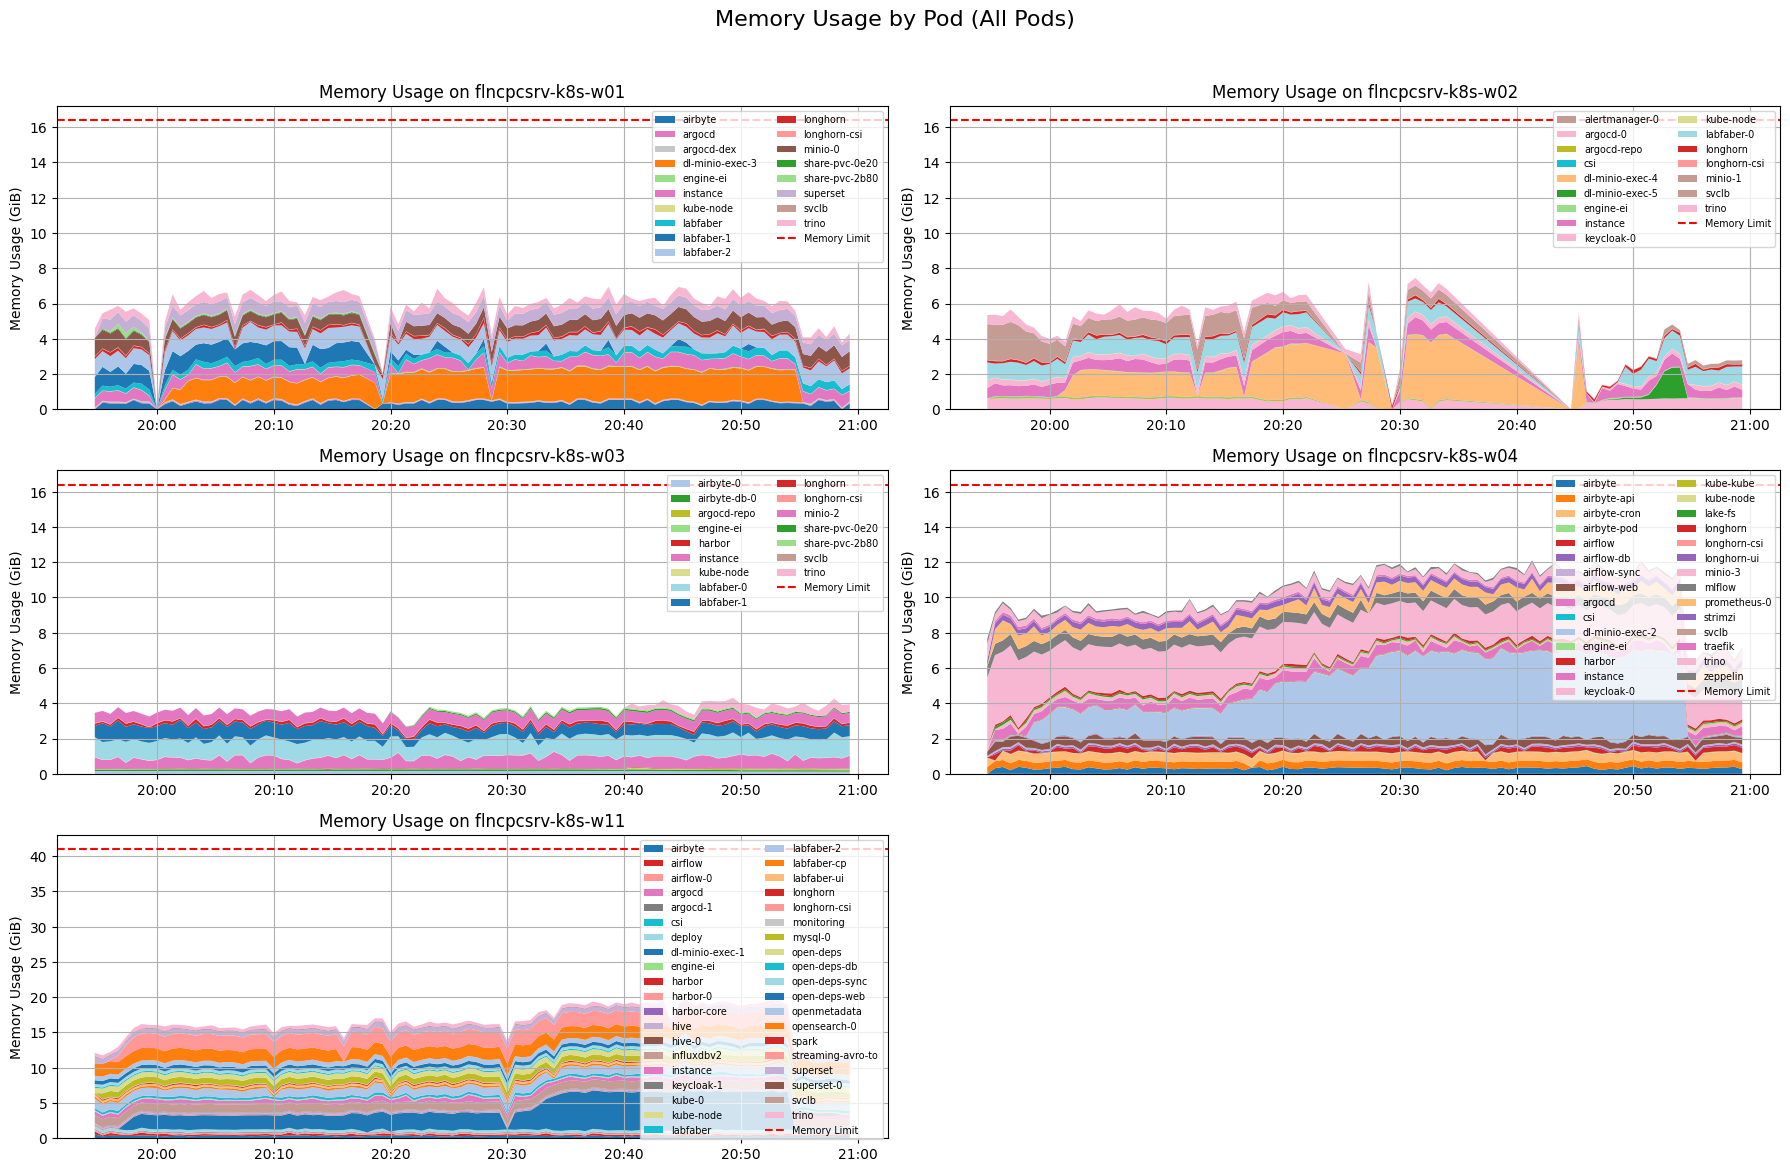

In [438]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

# === Step 1: Preprocessing ===
memory_df = df_container_memory_usage_bytes.sort_values(by=['timestamp', 'pod']).dropna(subset="container").copy()
memory_df["pod"] = memory_df["pod"].apply(simplify_pod_name)

# Convert bytes to MiB
memory_df['memory_gib'] = memory_df['value'] / (1024 * 1024 * 1024) # Gib

# Smooth using rolling average
memory_df['memory_gib_smoothed'] = memory_df.groupby('pod')['memory_gib'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Add memory limits in MiB
node_memory_limits = {
    'flncpcsrv-k8s-w01': 16.384,   # 16 GiB
    'flncpcsrv-k8s-w02': 16.384,
    'flncpcsrv-k8s-w03': 16.384,
    'flncpcsrv-k8s-w04': 16.384,
    'flncpcsrv-k8s-w11': 40.960,   # 40 GiB
}
memory_df['memory_limit'] = memory_df['node'].map(node_memory_limits)

# === Step 2: Resample every 30 seconds ===
memory_resampled = (
    memory_df[['timestamp', 'node', 'pod', 'id', 'memory_gib_smoothed']]
    .set_index('timestamp')
    .groupby(['node', 'pod', 'id'])
    .resample('40s')
    .mean(numeric_only=True)
    .reset_index()
)

# === Step 3: Color Palette ===
unique_pods = sorted(memory_df['pod'].unique())
palette = plt.get_cmap('tab20')
colors = [palette(i % palette.N) for i in range(len(unique_pods))]
pod_color_map = dict(zip(unique_pods, colors))

# === Step 4: Plotting ===
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12), sharex=False)
axes = axes.flatten()

for i, node in enumerate(node_memory_limits.keys()):
    ax = axes[i]
    node_data = memory_resampled[memory_resampled['node'] == node]

    if node_data.empty:
        ax.set_visible(False)
        continue

    pivot_df = node_data.pivot_table(
        index='timestamp',
        columns='pod',
        values='memory_gib_smoothed',
        aggfunc='mean'
    ).fillna(0).sort_index()

    present_pods = pivot_df.columns.tolist()
    colors_present = [pod_color_map[pod] for pod in present_pods]

    ax.stackplot(
        pivot_df.index,
        pivot_df.T.values,
        labels=present_pods,
        colors=colors_present
    )

    ax.set_title(f"Memory Usage on {node}")
    ax.set_ylabel("Memory Usage (GiB)")
    ax.axhline(y=node_memory_limits[node], color='red', linestyle='--', label='Memory Limit')
    ax.legend(loc='upper right', fontsize='x-small', ncol=2)
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Remove unused plots
for j in range(len(node_memory_limits), len(axes)):
    fig.delaxes(axes[j])

axes[-1].set_xlabel("Time")
fig.suptitle("Memory Usage by Pod (All Pods)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


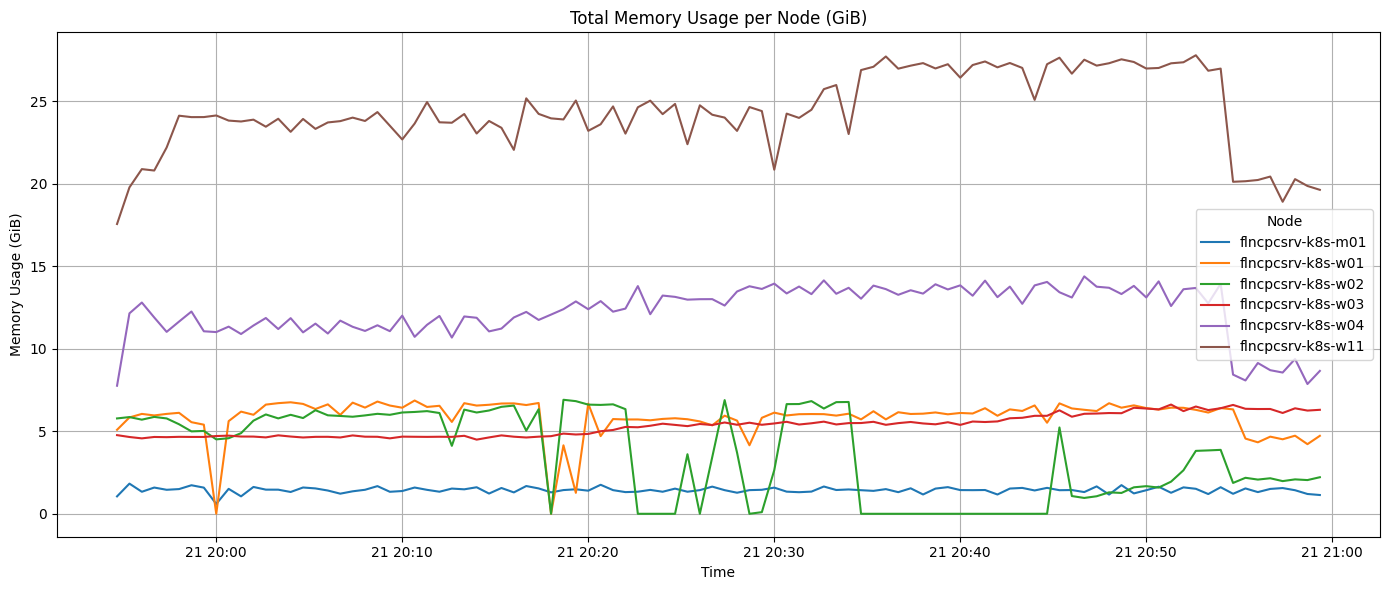

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load your memory dataset
memory_df = df_container_memory_usage_bytes.sort_values(by=['timestamp', 'pod']).dropna(subset="container").copy()

# === Preprocess Memory usage ===
memory_df_proc = memory_df.sort_values(by=["timestamp", "pod"]).copy()
memory_df_proc["memory_gib"] = memory_df_proc["value"] / (1024 ** 3)  # bytes → GiB
memory_df_proc["memory_gib_smoothed"] = memory_df_proc.groupby("pod")["memory_gib"].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# === Aggregate by node and resample ===
memory_df_proc["node"] = memory_df_proc["node"].astype(str)

memory_resampled = (
    memory_df_proc[['timestamp', 'node', 'pod', 'id', 'memory_gib_smoothed']]
    .set_index('timestamp')
    .groupby(['node', 'pod', 'id'])
    .resample('40s')
    .mean(numeric_only=True)
    .reset_index()
)

total_mem_per_node = (
    memory_resampled
    .groupby(['timestamp', 'node'])['memory_gib_smoothed']
    .sum()
    .unstack(level='node')
    .fillna(0)
)

# === Plot Memory ===
plt.figure(figsize=(14, 6))
for node in total_mem_per_node.columns:
    plt.plot(total_mem_per_node.index, total_mem_per_node[node], label=node)

plt.title("Total Memory Usage per Node (GiB) - All Pods")
plt.xlabel("Time")
plt.ylabel("Memory Usage (GiB)")
plt.legend(title="Node")
plt.grid(True)
plt.tight_layout()
plt.show()


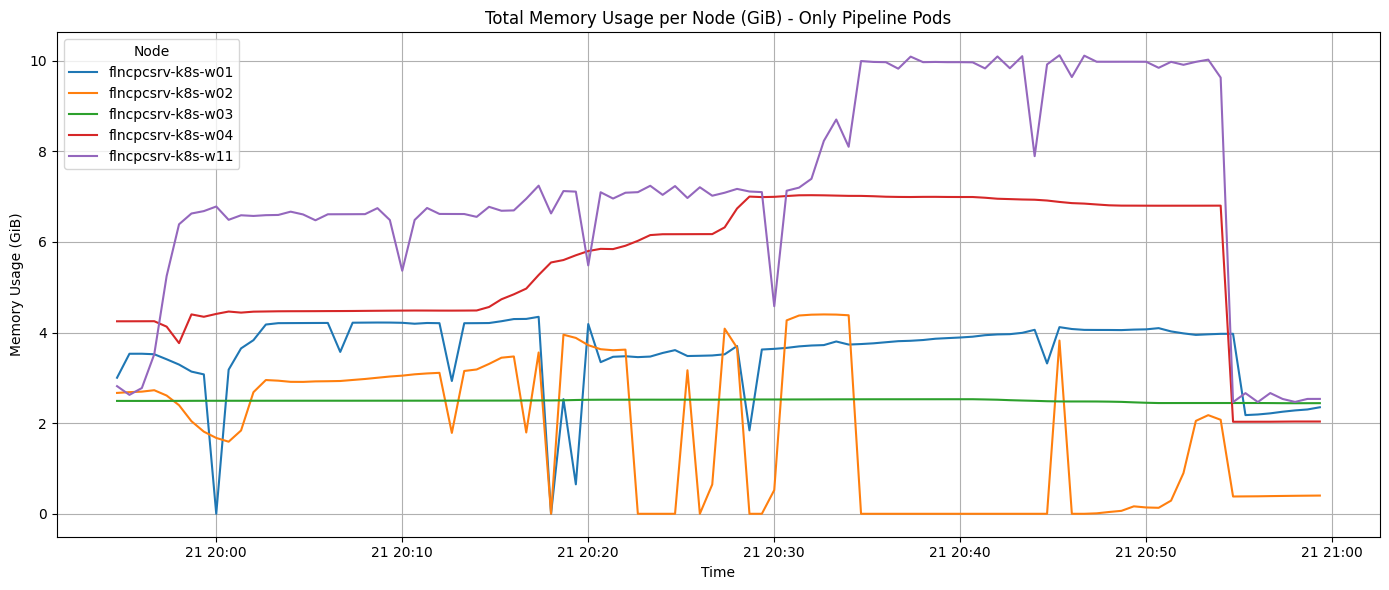

In [423]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load your memory dataset
memory_df = df_container_memory_usage_bytes_filtered.sort_values(by=['timestamp', 'pod']).dropna(subset="container").copy()

# === Preprocess Memory usage ===
memory_df_proc = memory_df.sort_values(by=["timestamp", "pod"]).copy()
memory_df_proc["memory_gib"] = memory_df_proc["value"] / (1024 ** 3)  # bytes → GiB
memory_df_proc["memory_gib_smoothed"] = memory_df_proc.groupby("pod")["memory_gib"].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# === Aggregate by node and resample ===
memory_df_proc["node"] = memory_df_proc["node"].astype(str)

memory_resampled = (
    memory_df_proc[['timestamp', 'node', 'pod', 'id', 'memory_gib_smoothed']]
    .set_index('timestamp')
    .groupby(['node', 'pod', 'id'])
    .resample('40s')
    .mean(numeric_only=True)
    .reset_index()
)

total_mem_per_node = (
    memory_resampled
    .groupby(['timestamp', 'node'])['memory_gib_smoothed']
    .sum()
    .unstack(level='node')
    .fillna(0)
)

# === Plot Memory ===
plt.figure(figsize=(14, 6))
for node in total_mem_per_node.columns:
    plt.plot(total_mem_per_node.index, total_mem_per_node[node], label=node)

plt.title("Total Memory Usage per Node (GiB) - Only Pipeline Pods")
plt.xlabel("Time")
plt.ylabel("Memory Usage (GiB)")
plt.legend(title="Node")
plt.grid(True)
plt.tight_layout()
plt.show()


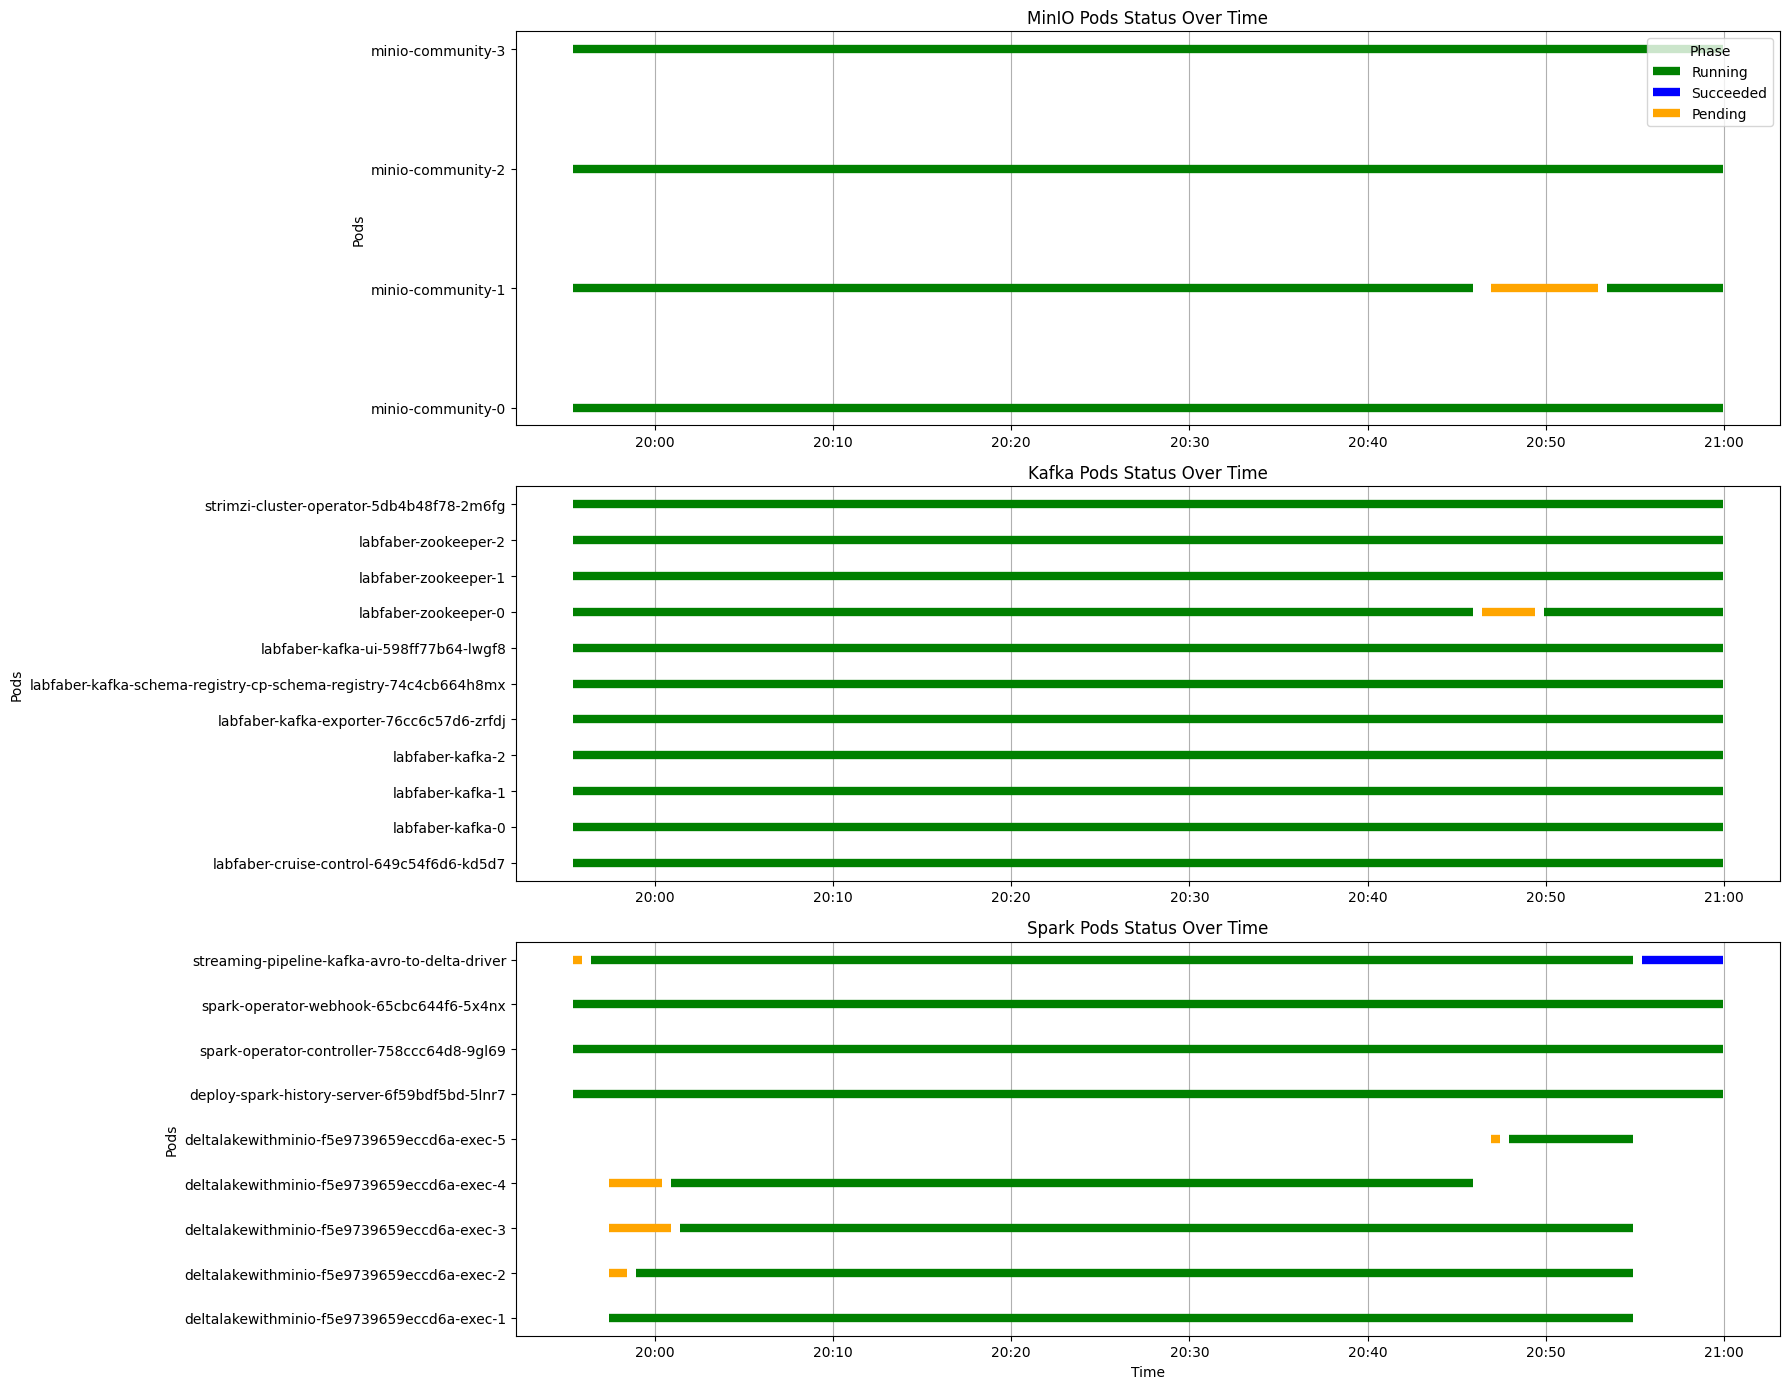

In [424]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Only active status
df = df_kube_pod_status_phase[df_kube_pod_status_phase['value'] == 1.0].copy()
df = df.sort_values(["pod", "timestamp"])

# === Step 1: Group definitions ===
group_definitions = {
    "MinIO": ['minio-community'],
    "Kafka": [
        'labfaber-cruise-control',
        'labfaber-kafka',
        'labfaber-kafka-schema-registry',
        'labfaber-kafka-ui',
        'labfaber-zookeeper',
        'strimzi-cluster-operator'
    ],
    "Spark": [
        'deltalakewithminio',
        'deploy-spark-history-server',
        'streaming-pipeline-kafka-avro-to-delta-driver',
        'spark-operator-controller',
        'spark-operator-webhook'
    ]
}

phase_colors = {
    'Running': 'green',
    'Pending': 'orange',
    'Failed': 'red',
    'Succeeded': 'blue',
    'Unknown': 'gray'
}

fig, axes = plt.subplots(nrows=3, figsize=(18, 14), sharex=False)

for ax, (group_name, prefixes) in zip(axes, group_definitions.items()):
    group_df = df[df['pod'].apply(lambda p: any(p.startswith(prefix) for prefix in prefixes))].copy()

    # Assign y positions
    unique_pods = sorted(group_df['pod'].unique())
    pod_to_y = {pod: i for i, pod in enumerate(unique_pods)}

    # Track segments
    seen_phases = set()

    for pod in unique_pods:
        pod_df = group_df[group_df['pod'] == pod].copy()

        pod_df['phase_shift'] = (pod_df['phase'] != pod_df['phase'].shift()).cumsum()
        for _, seg in pod_df.groupby('phase_shift'):
            if seg.empty:
                continue
            phase = seg['phase'].iloc[0]
            label = phase if phase not in seen_phases else None
            seen_phases.add(phase)

            start = seg['timestamp'].iloc[0]
            end = seg['timestamp'].iloc[-1]
            ax.hlines(
                y=pod_to_y[pod],
                xmin=start,
                xmax=end,
                colors=phase_colors.get(phase, 'black'),
                linewidth=6,
                label=label
            )

    ax.set_yticks(list(pod_to_y.values()))
    ax.set_yticklabels(list(pod_to_y.keys()))
    ax.set_title(f"{group_name} Pods Status Over Time")
    ax.set_ylabel("Pods")
    ax.grid(True, axis='x')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Label and legend
axes[-1].set_xlabel("Time")
handles, labels = axes[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[0].legend(by_label.values(), by_label.keys(), title="Phase", loc='upper right')

plt.tight_layout()
plt.show()


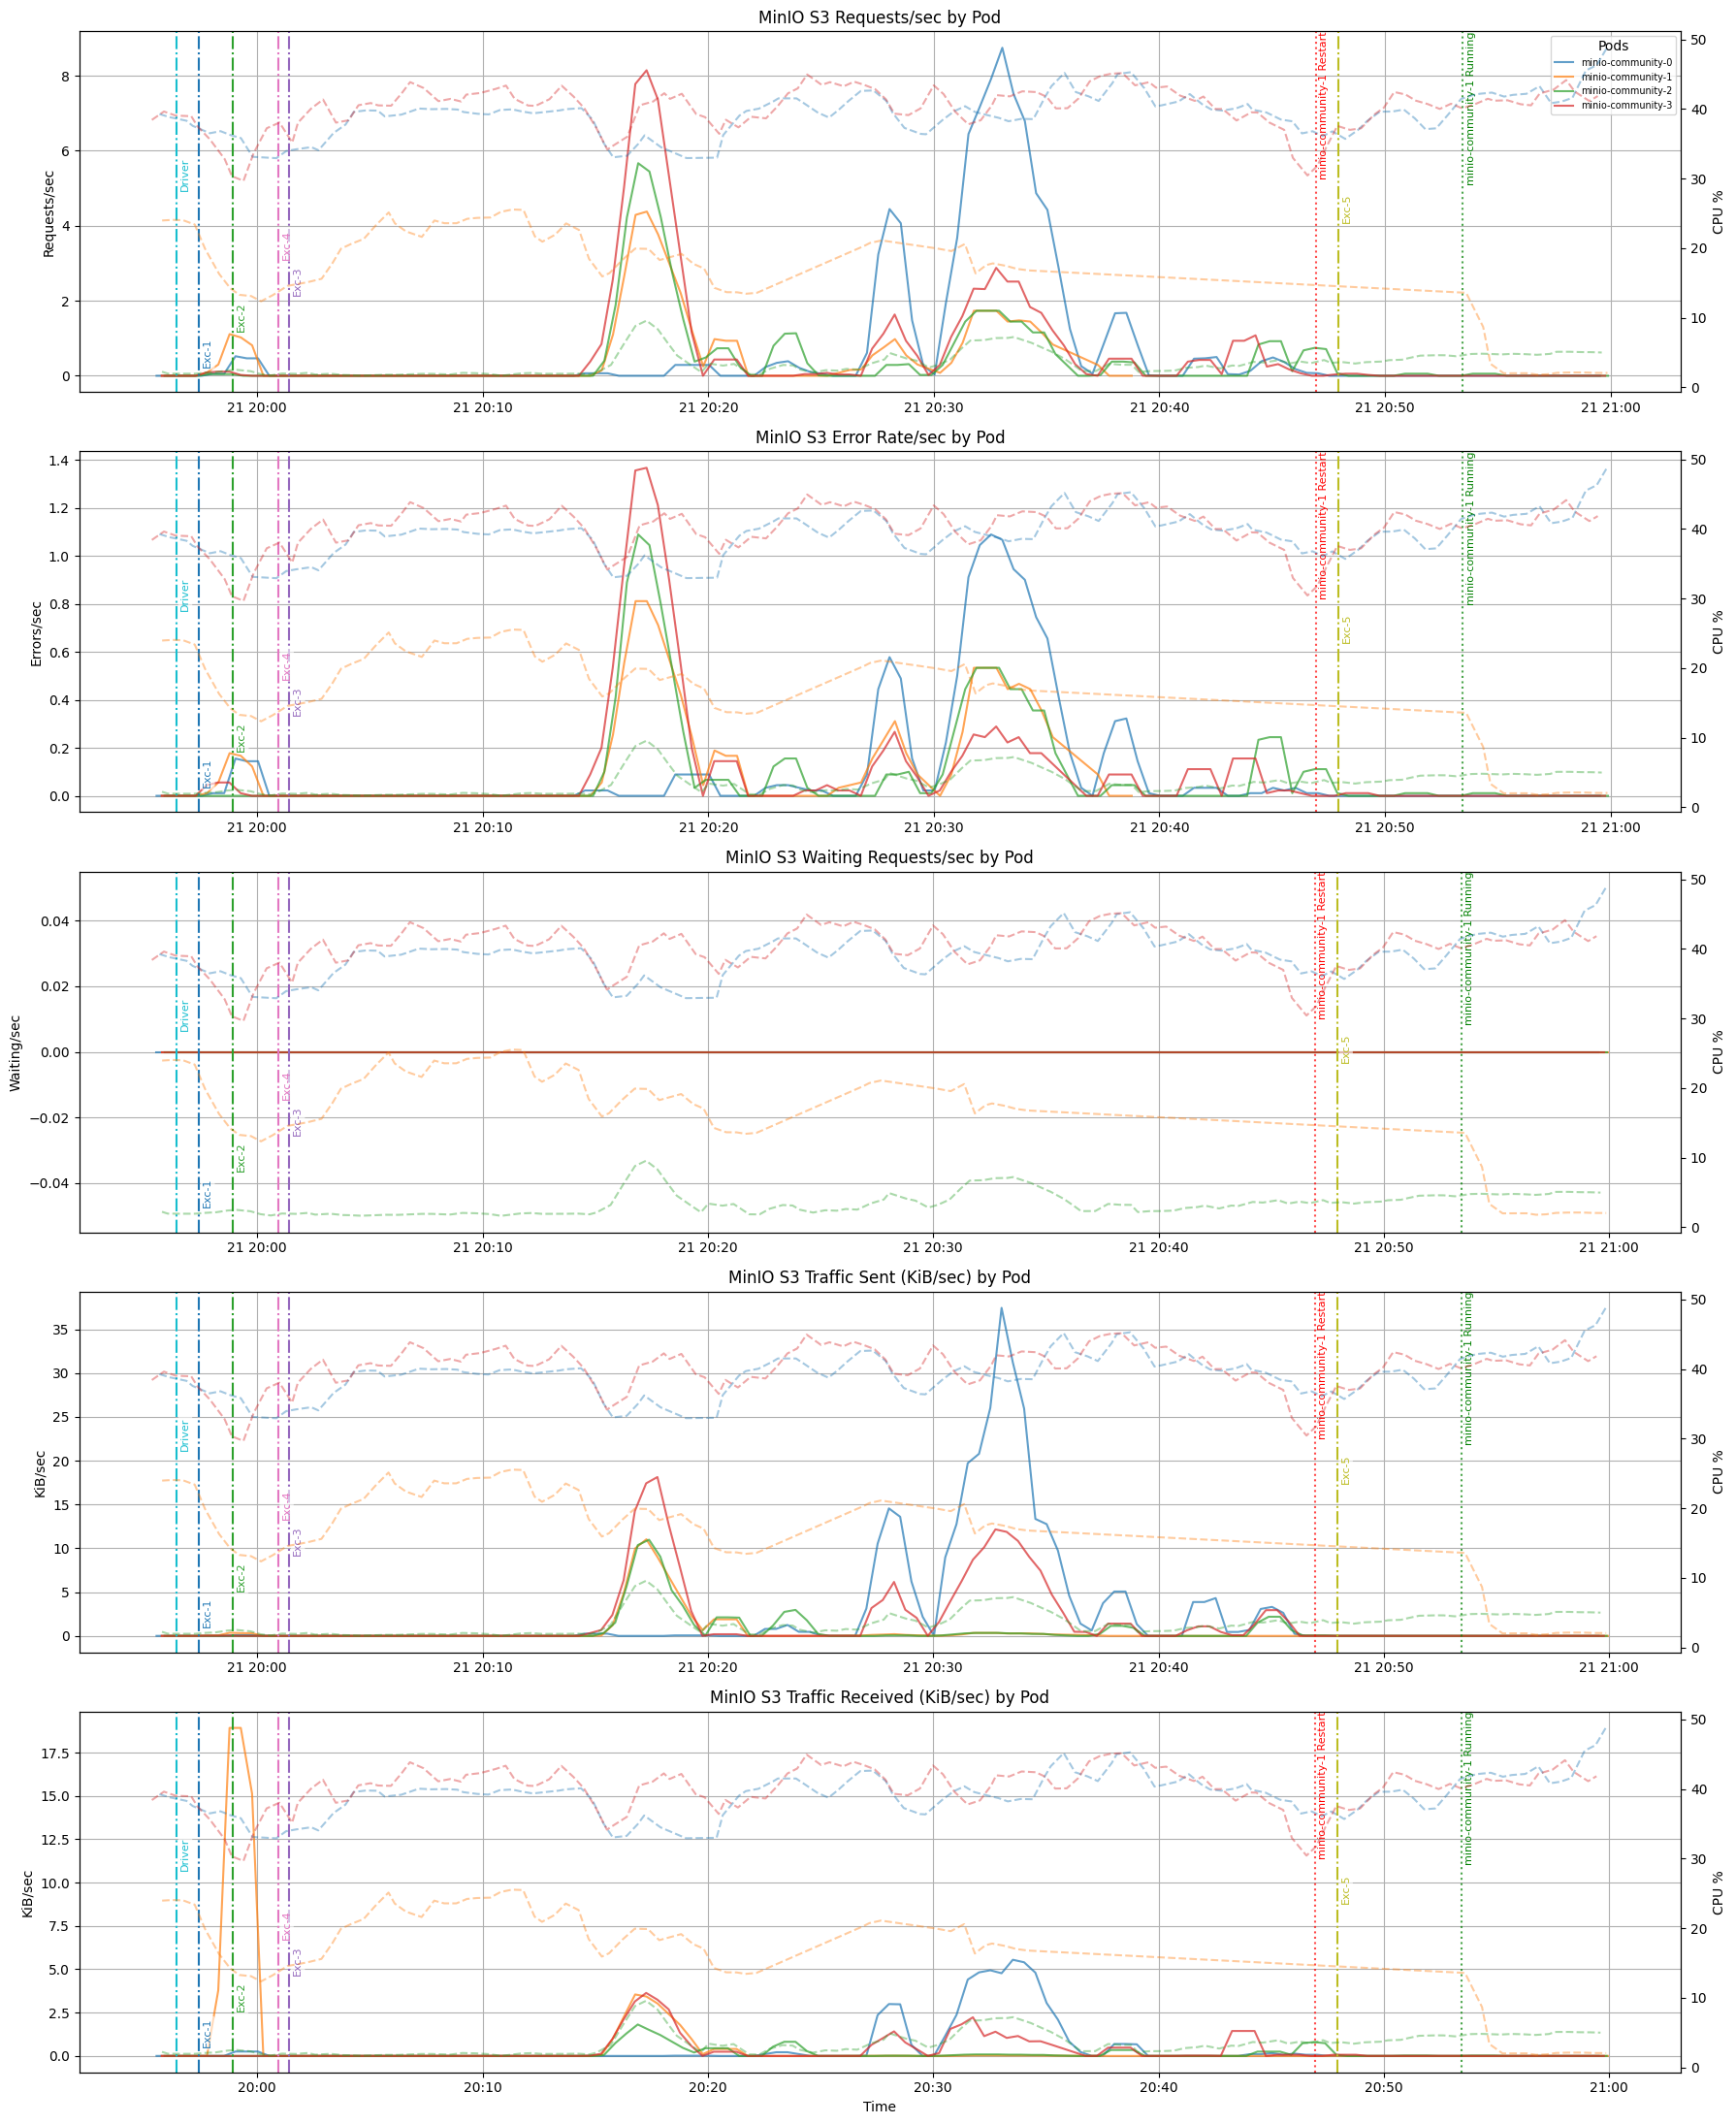

In [433]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === Load all MinIO metric CSVs ===
df_minio_incoming = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_incoming_total.parquet').reset_index())
df_minio_total = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_total.parquet').reset_index())
df_minio_waiting = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_waiting_total.parquet').reset_index())
df_minio_errors = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_errors_total.parquet').reset_index())
df_minio_sent_bytes = time_filter(pd.read_parquet(base_path + '/minio_s3_traffic_sent_bytes.parquet').reset_index())
df_minio_received_bytes = time_filter(pd.read_parquet(base_path + '/minio_s3_traffic_received_bytes.parquet').reset_index())

# === Process counter-based metrics to smoothed rate ===
def process_rate(df):
    df = df.sort_values(by=['timestamp', 'pod']).dropna(subset="container")
    df['value_diff'] = df.groupby('pod')['value'].diff()
    df['time_diff'] = df.groupby('pod')['timestamp'].diff().dt.total_seconds()
    df = df[(df['value_diff'] >= 0) & (df['time_diff'] > 0)].copy()
    df['rate'] = df['value_diff'] / df['time_diff']
    df['rate_smoothed'] = df.groupby('pod')['rate'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    return df

def aggregate_and_process(df):
    df = df.sort_values(by=['timestamp', 'pod'])
    df = df.groupby(['timestamp', 'pod', 'container'], as_index=False)['value'].sum()
    df = process_rate(df)
    return df

# === Apply processing ===
df_total_proc = aggregate_and_process(df_minio_total)
df_errors_proc = aggregate_and_process(df_minio_errors)
df_waiting_proc = aggregate_and_process(df_minio_waiting)
df_sent_proc = process_rate(df_minio_sent_bytes)
df_sent_proc['rate_smoothed'] /= (1024)  # Bytes → KiB
df_received_proc = process_rate(df_minio_received_bytes)
df_received_proc['rate_smoothed'] /= (1024)  # Bytes → KiB

# === Load and process CPU usage ===
cpu_df = df_container_cpu_usage_seconds_total.sort_values(by=['id', 'pod', 'timestamp']).dropna(subset="container").copy()
cpu_df['value_diff'] = cpu_df.groupby('id')['value'].diff()
cpu_df['time_diff'] = cpu_df.groupby('id')['timestamp'].diff().dt.total_seconds()
cpu_df = cpu_df[(cpu_df['value_diff'] > 0) & (cpu_df['time_diff'] > 0)].copy()
cpu_df['rate'] = (cpu_df['value_diff'] / cpu_df['time_diff']) * 100
cpu_df['cpu_percent_smoothed'] = cpu_df.groupby('pod')['rate'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
minio_cpu_df = cpu_df[cpu_df['pod'].str.startswith("minio-community")].copy()

# === Detect actual pod restart cycles: Pending → Running ===
status_df = df_kube_pod_status_phase[df_kube_pod_status_phase['pod'].str.startswith('minio-community')].copy()
status_df = status_df[status_df['value'] == 1.0].sort_values(['pod', 'timestamp'])

restart_events = []

for pod, pod_df in status_df.groupby('pod'):
    pod_df = pod_df.reset_index(drop=True)
    for i in range(1, len(pod_df)):
        prev_row = pod_df.iloc[i - 1]
        curr_row = pod_df.iloc[i]

        if prev_row['phase'] != 'Pending' and curr_row['phase'] == 'Pending':
            # Start of a restart
            restart_time = curr_row['timestamp']

            # Find next running status
            running_rows = pod_df[(pod_df['timestamp'] > restart_time) & (pod_df['phase'] == 'Running')]
            if not running_rows.empty:
                running_time = running_rows.iloc[0]['timestamp']
            else:
                running_time = None

            restart_events.append({
                'pod': pod,
                'restart_time': restart_time,
                'running_time': running_time
            })

restarts_df = pd.DataFrame(restart_events)


# === Helper to plot metric + CPU + annotations ===
def plot_with_cpu_overlay(ax, metric_df, cpu_df, title, ylabel_left):
    ax
    for pod, pod_df in metric_df.groupby('pod'):
        ax.plot(pod_df['timestamp'], pod_df['rate_smoothed'], label=pod, alpha=0.7)
    ax.set_ylabel(ylabel_left)
    ax.grid(True)

    # Right axis for CPU
    ax_right = ax.twinx()
    for pod, pod_df in cpu_df.groupby('pod'):
        ax_right.plot(pod_df['timestamp'], pod_df['cpu_percent_smoothed'], linestyle='--', alpha=0.4, label=f'{pod} CPU')
    ax_right.set_ylabel("CPU %")

    # Restart annotations (Pending + Running)
    for _, row in restarts_df.iterrows():
        pod = row['pod']
        restart_time = row['restart_time']
        running_time = row['running_time']

        if restart_time:
            ax.axvline(x=restart_time, color='red', linestyle=':', alpha=0.7)
            ax.text(restart_time + pd.Timedelta(seconds=10), ax.get_ylim()[1], f'{pod} Restart', color='red', fontsize=8, rotation=90, verticalalignment='top')

        if pd.notna(running_time):
            ax.axvline(x=running_time, color='green', linestyle=':', alpha=0.7)
            ax.text(running_time + pd.Timedelta(seconds=10), ax.get_ylim()[1], f'{pod} Running', color='green', fontsize=8, rotation=90, verticalalignment='top')


    annotate_spark_starts(ax, metric_df, top_offset=0.15, top_offset_inc=0.1, label_offset_secs=10)

    ax.set_title(title)
    return ax, ax_right

# === Generate 5-panel figure ===
fig, axes = plt.subplots(nrows=5, figsize=(18, 22), sharex=False)

plot_with_cpu_overlay(axes[0], df_total_proc, minio_cpu_df, "MinIO S3 Requests/sec by Pod", "Requests/sec")
plot_with_cpu_overlay(axes[1], df_errors_proc, minio_cpu_df, "MinIO S3 Error Rate/sec by Pod", "Errors/sec")
plot_with_cpu_overlay(axes[2], df_waiting_proc, minio_cpu_df, "MinIO S3 Waiting Requests/sec by Pod", "Waiting/sec")
plot_with_cpu_overlay(axes[3], df_sent_proc, minio_cpu_df, "MinIO S3 Traffic Sent (KiB/sec) by Pod", "KiB/sec")
plot_with_cpu_overlay(axes[4], df_received_proc, minio_cpu_df, "MinIO S3 Traffic Received (KiB/sec) by Pod", "KiB/sec")

axes[-1].set_xlabel("Time")
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes[0].legend(loc='upper right', fontsize='x-small', title='Pods')
plt.tight_layout()
plt.show()


No start time detected.
No start time detected.
No start time detected.
No start time detected.


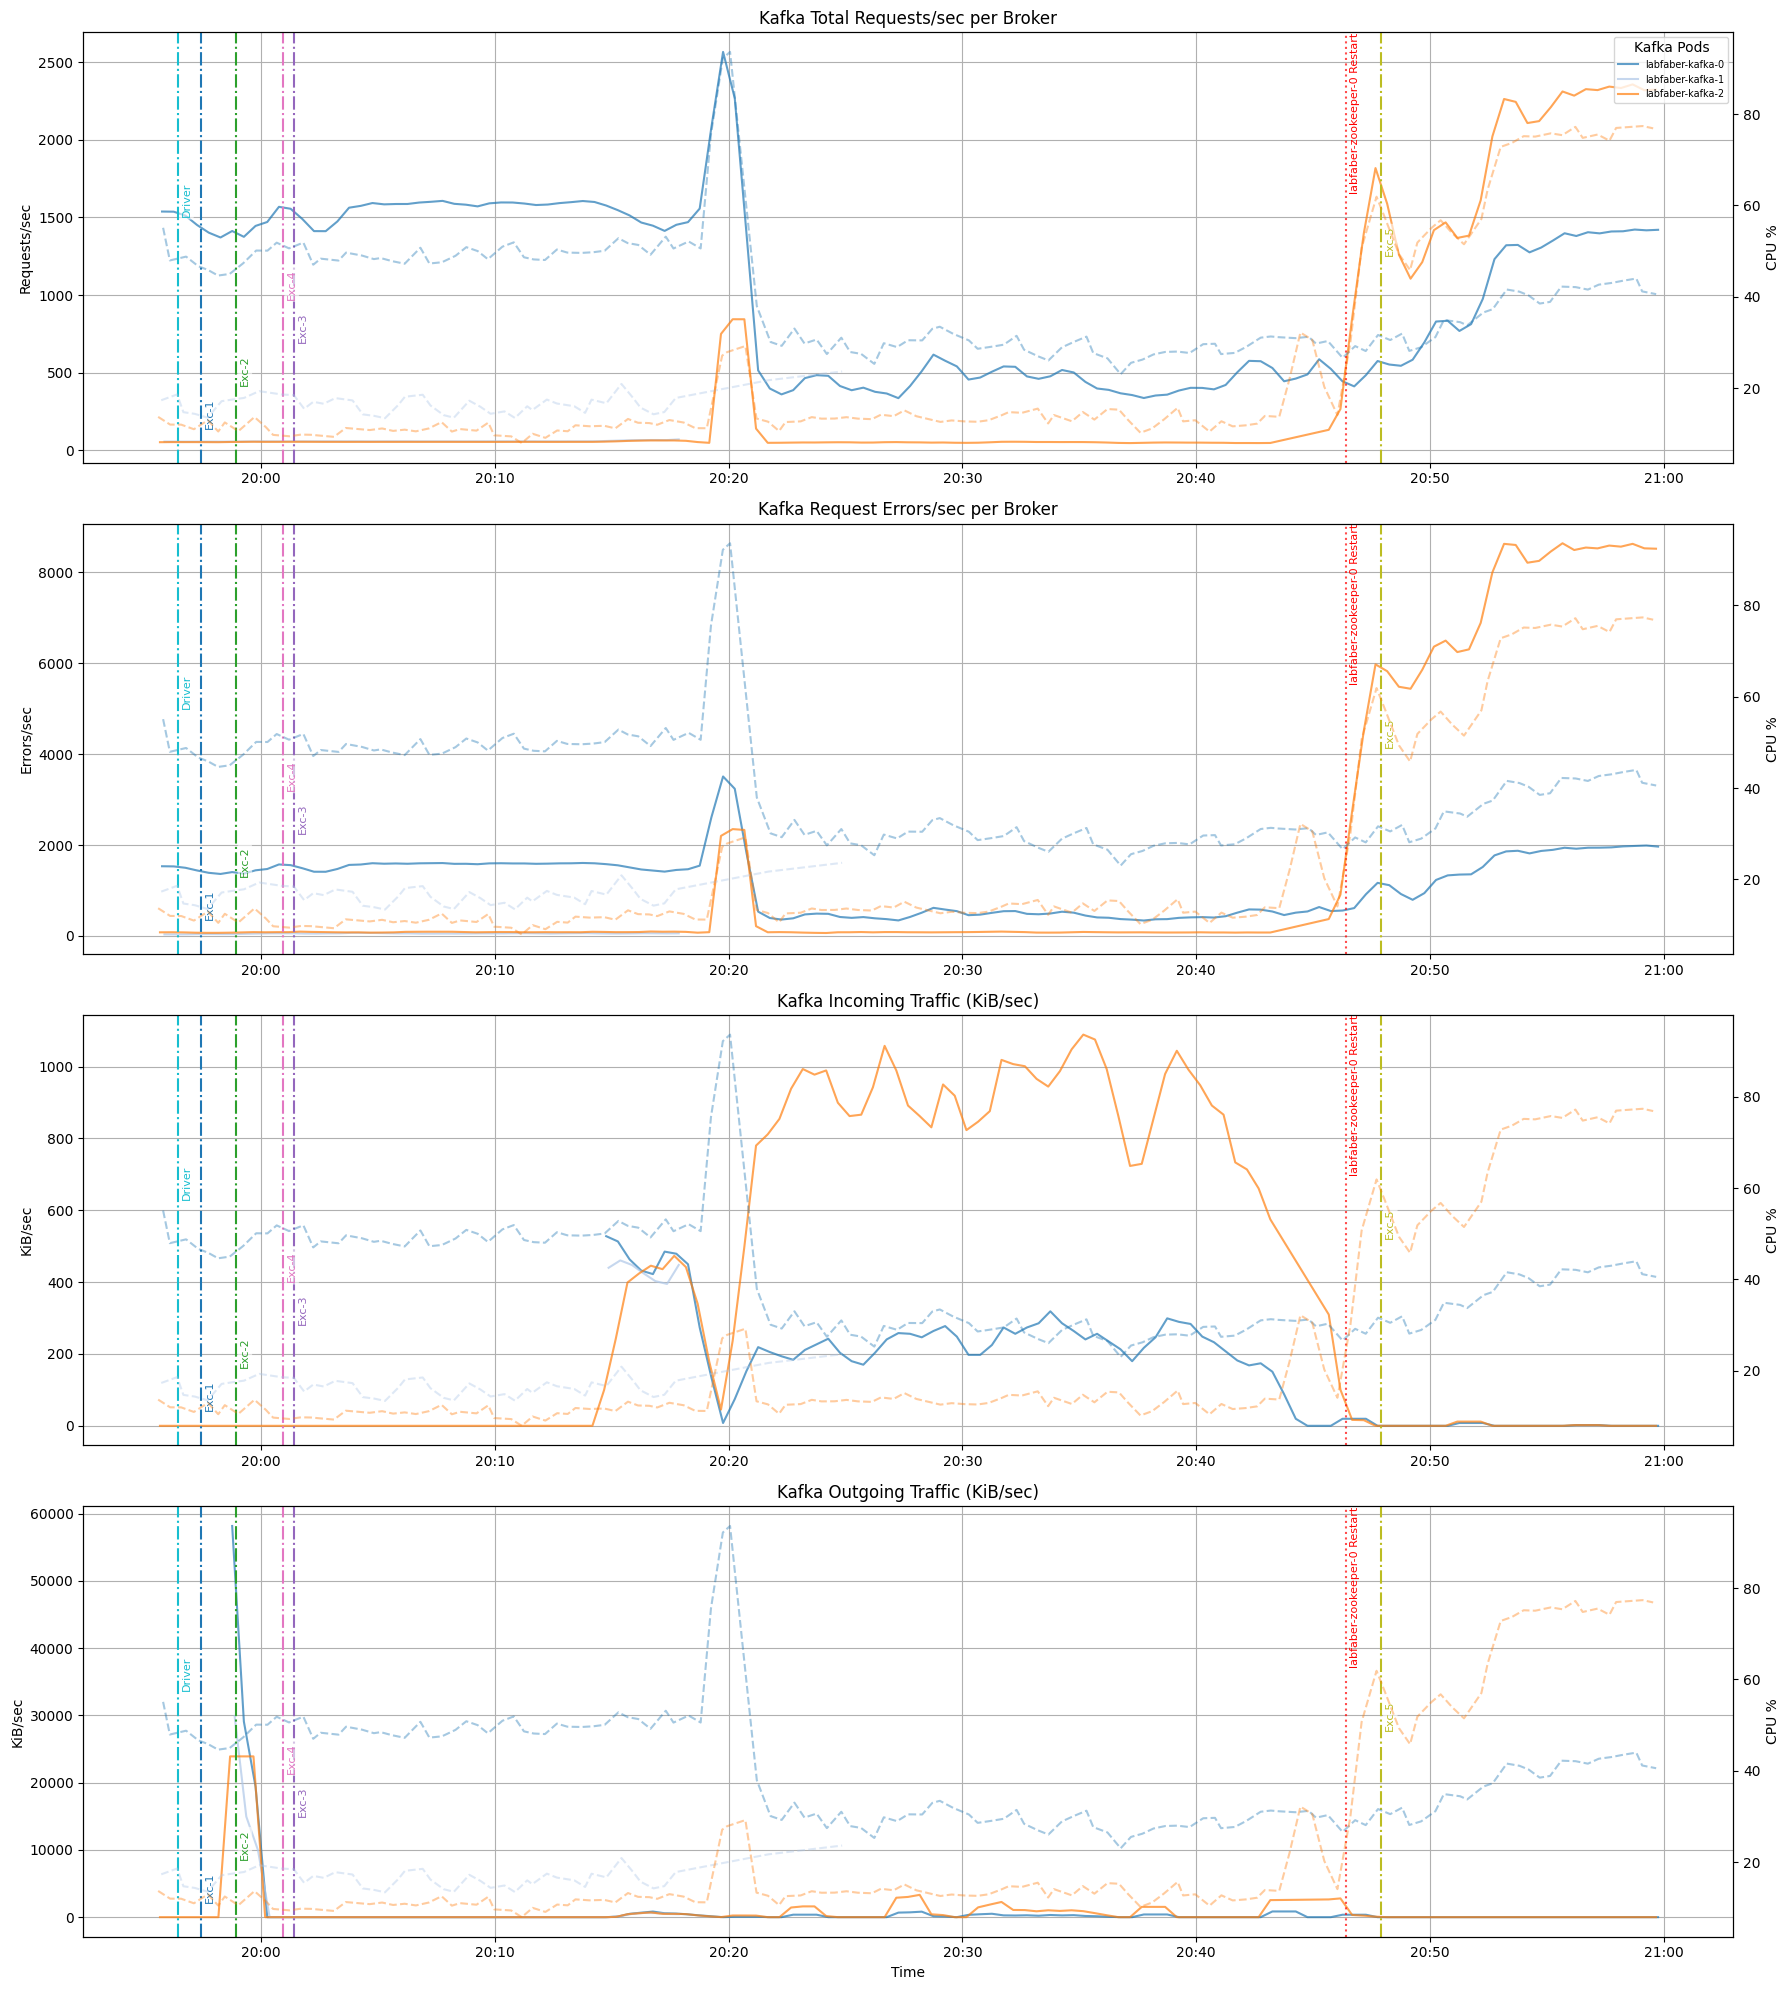

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

# === Utility functions ===

def process_rate(df):
    df = df.sort_values(by=['timestamp', 'pod']).dropna(subset=["container"])
    df['value_diff'] = df.groupby('pod')['value'].diff()
    df['time_diff'] = df.groupby('pod')['timestamp'].diff().dt.total_seconds()
    df = df[(df['value_diff'] >= 0) & (df['time_diff'] > 0)].copy()
    df['rate'] = df['value_diff'] / df['time_diff']
    df['rate_smoothed'] = df.groupby('pod')['rate'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    return df

def aggregate_and_process(df):
    df = df.sort_values(by=['timestamp', 'pod'])
    df = df.groupby(['timestamp', 'pod', 'container'], as_index=False)['value'].sum()
    return process_rate(df)

def annotate_kafka_restarts(ax, restart_df):
    for _, row in restart_df.iterrows():
        try:
            ax.axvline(x=row['restart_time'], color='red', linestyle=':', alpha=0.7)
            ax.text(row['restart_time'] + pd.Timedelta(seconds=10), ax.get_ylim()[1], f"{row['pod']} Restart", color='red', fontsize=8,
                    rotation=90, verticalalignment='top')
        except KeyError:
            print("No restart time detected.")
        try:
            ax.axvline(x=row['start_time'], color='green', linestyle=':', alpha=0.7)
            ax.text(row['start_time'] + pd.Timedelta(seconds=10), ax.get_ylim()[1]*0.95, f"{row['pod']} Running", color='green', fontsize=8,
                    rotation=90, verticalalignment='top')
        except KeyError:
            print("No start time detected.")

def plot_kafka_metric_with_cpu(ax, metric_df, cpu_df, title, ylabel, restarts_df, color_map):
    for pod, pod_df in metric_df.groupby("pod"):
        ax.plot(pod_df["timestamp"], pod_df["rate_smoothed"], label=pod, color=color_map.get(pod), alpha=0.7)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)

    # CPU overlay
    ax_right = ax.twinx()
    for pod, pod_df in cpu_df.groupby("pod"):
        ax_right.plot(pod_df["timestamp"], pod_df["cpu_percent_smoothed"], linestyle='--', label=f'{pod} CPU', color=color_map.get(pod, 'gray'), alpha=0.4)
    ax_right.set_ylabel("CPU %")

    # Restart annotations
    annotate_kafka_restarts(ax, restarts_df)

    annotate_spark_starts(ax, metric_df, top_offset=0.15, top_offset_inc=0.1, label_offset_secs=10)

    return ax, ax_right

# === Preprocess input metrics ===
df_bytes_in = aggregate_and_process(bytes_in[bytes_in['topic'] == 'control_power-avro'])
df_bytes_out = aggregate_and_process(bytes_out[bytes_out['topic'] == 'control_power-avro'])
df_requests = aggregate_and_process(requests)
df_errors = aggregate_and_process(errors)
df_messages_in = process_rate(messages_in[messages_in['topic'] == 'control_power-avro'])
df_consumer_outgoing = aggregate_and_process(consumer_outgoing)

df_sent_proc['rate_smoothed'] /= (1024)  # Bytes → KiB
df_received_proc['rate_smoothed'] /= (1024)  # Bytes → KiB

# === CPU usage ===
cpu_df = df_container_cpu_usage_seconds_total_filtered.sort_values(by=['pod', 'timestamp']).dropna(subset=["container"])
cpu_df['value_diff'] = cpu_df.groupby('id')['value'].diff()
cpu_df['time_diff'] = cpu_df.groupby('id')['timestamp'].diff().dt.total_seconds()
cpu_df = cpu_df[(cpu_df['value_diff'] > 0) & (cpu_df['time_diff'] > 0)].copy()
cpu_df['rate'] = (cpu_df['value_diff'] / cpu_df['time_diff']) * 100
cpu_df['cpu_percent_smoothed'] = cpu_df.groupby('pod')['rate'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
kafka_cpu_df = cpu_df[cpu_df['pod'].str.contains("labfaber-kafka", case=False)]
kafka_cpu_df = kafka_cpu_df[kafka_cpu_df['container'] == "kafka"]

# === Pod restarts ===

def detect_pod_restart_and_running(df_kube_pod_status_phase):
    df = df_kube_pod_status_phase
    df = df[df['pod'].str.startswith("labfaber-kafka") | df['pod'].str.startswith("labfaber-zookeeper")]
    df = df[df['value'] == 1.0]
    df = df.sort_values(['pod', 'timestamp'])

    restart_records = []

    for pod, pod_df in df.groupby('pod'):
        pod_df = pod_df.reset_index(drop=True)
        for i in range(1, len(pod_df)):
            prev_row = pod_df.iloc[i - 1]
            curr_row = pod_df.iloc[i]

            if prev_row['phase'] != 'Pending' and curr_row['phase'] == 'Pending':
                # Start of a restart
                restart_time = curr_row['timestamp']

                # Find next running status
                running_rows = pod_df[(pod_df['timestamp'] > restart_time) & (pod_df['phase'] == 'Running')]
                if not running_rows.empty:
                    running_time = running_rows.iloc[0]['timestamp']
                else:
                    running_time = None

                restart_records.append({
                    'pod': pod,
                    'restart_time': restart_time,
                    'running_time': running_time
                })

    return pd.DataFrame(restart_records)


restarts_df = detect_pod_restart_and_running(df_kube_pod_status_phase)

# === Color map ===
all_pods = sorted(set(df_requests['pod'].unique()) |
                set(df_errors['pod'].unique()) |
                set(df_bytes_in['pod'].unique()) |
                set(df_bytes_out['pod'].unique()))
palette = plt.get_cmap('tab20')
colors = [palette(i % palette.N) for i in range(len(all_pods))]
color_map = dict(zip(all_pods, colors))

# === Plotting ===
fig, axes = plt.subplots(4, 1, figsize=(18, 20), sharex=False)

plot_kafka_metric_with_cpu(
    axes[0], df_requests, kafka_cpu_df,
    "Kafka Total Requests/sec per Broker", "Requests/sec",
    restarts_df, color_map
)

plot_kafka_metric_with_cpu(
    axes[1], df_errors, kafka_cpu_df,
    "Kafka Request Errors/sec per Broker", "Errors/sec",
    restarts_df, color_map
)

plot_kafka_metric_with_cpu(
    axes[2], df_bytes_in, kafka_cpu_df,
    "Kafka Incoming Traffic (KiB/sec)", "KiB/sec",
    restarts_df, color_map
)

plot_kafka_metric_with_cpu(
    axes[3], df_bytes_out, kafka_cpu_df,
    "Kafka Outgoing Traffic (KiB/sec)", "KiB/sec",
    restarts_df, color_map
)

# === Format ===
axes[-1].set_xlabel("Time")
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

axes[0].legend(loc='upper right', fontsize='x-small', title="Kafka Pods")
plt.tight_layout()
plt.show()
